# 1. 텍스트 데이터 수집 (네이버 블로그, 네이버 뉴스 이용)

### 주제: 경제
### 키워드
- <span style = 'font-size:1.1em;line-height:1.5em'>주식</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>채권</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>적금</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>예금</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>신용카드</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>체크카드</span>
- <span style = 'font-size:1.1em;line-height:1.5em'>경제</span>

### 필요한 모듈 불러오기

In [83]:
from selenium import webdriver
driver = webdriver.Chrome('C:\\Users\\user\\chromedriver\\chromedriver.exe')
import os
import sys
import time
import urllib.request
import datetime
import time
import json
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

C:\Users\user\AppData\Local\Temp\ipykernel_10456\2418869372.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('C:\\Users\\user\\chromedriver\\chromedriver.exe')


### 네이버 블로그 API를 이용하여 데이터 수집

In [132]:
base_url = 'https://openapi.naver.com/v1/search/blog.json' #end_point
client_id =
client_secret =
query = '경제' # 검색어
encText = urllib.parse.quote(query)
n_display = 100 # 한 번에 표시할 검색 결과 개수(기본값: 10, 최댓값: 100)
start = 1000
sort = 'sim'

url = f'{base_url}?query={encText}&display={n_display}&start={start}&sort={sort}'
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
response = urllib.request.urlopen(request)
rescode = response.getcode()

if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)
    
search_result_str = response_body.decode('utf-8')
search_results = json.loads(search_result_str)

### 기본적인 Cleaning 작업을 수행하는 함수

In [133]:
titles = []
links = []
contents = []


## 태그를 지우는 함수입니다.
def remove_tag(my_str):
    
    p = re.compile('(<([^>]+)>)')
    return p.sub('', my_str)

## 특수문자를 나타내는 &apos;, &quot를 실제 특수문자로 변환하는 함수 입니다.
def sub_html_special_char(my_str):
    p1 = re.compile('&lt;')
    p2 = re.compile('&gt;')
    p3 = re.compile('&amp;')
    p4 = re.compile('&apos;')
    p5 = re.compile('&quot;')

    result = p1.sub('\<', my_str)
    result = p2.sub('\>', result)
    result = p3.sub('\&', result)
    result = p4.sub('\'', result)
    result = p5.sub('\"', result)
    return result

#줄바꿈 문자를 제거하는 함수입니다.
def remove_newlines(my_str): 
    return my_str.replace('\n', '').replace('\r', '')

In [134]:
response = requests.get(url)
html = response.content
p = re.compile('https://blog.naver.com+')

for i, item in enumerate(search_results['items']):
    if p.match(item['link']):# 블로그 링크 중에 https://blog.naver.com으로 시작하지 않는 페이지가 존재하므로 네이버 블로그 결과만 추출합니다      
        # 네이버 블로그, 카페의 본문은 iframe 태그의 src = ''에 특정주소를 붙여줘야 접근이 가능하다고 합니다.
        response = requests.get(item['link']) #requests 모듈을 이용해서 원하는 블로그의 link를 가져옵니다.
        html = response.text # HTTP 응답에서 본문(content)을 문자열 형태로 디코딩하여 반환합니다
        soup = BeautifulSoup(html, 'html.parser') # BeauifulSoup 라이브러리를 사용하여 html을 파싱할 수 있도록합니다.
        iframe_src = soup.find('iframe')['src'] # iframe 태그의 src 주소를 가져옵니다.
        url = f"https://blog.naver.com{iframe_src}" #'/PostView.naver?blogId=sun1060&logNo=223022743989&redirect=Dlog&widgetTypeCall=true&directAccess=false'
        url_open = urllib.request.urlopen(url) # 이제 새로운 url을 통해 블로그의 본문에 접근 할 수 있습니다.
        iframe_soup = BeautifulSoup(url_open, 'html.parser') # 새로운 url을 BeauifulSoup 라이브러리를 사용하여 html을 파싱할 수 있도록합니다.
        content = iframe_soup.find_all('div', {'class':'se-main-container'}) # 본문의 내용을 가져옵니다.
        if len(content) > 0: # 컨텐츠의 내용이 하나 이상이면
            real_contents = sub_html_special_char(remove_newlines(remove_tag(content[0].text))) # 기본적인 전처리를 수행하고
            contents.append(real_contents) # 컨텐츠의 내용을 contents 리스트에 추가합니다.
            title = sub_html_special_char(remove_tag(item['title'])) # 전처리 전 기본적인 cleaning 작업을 수행하는 함수입니다.
            link = item['link'] # 링크는 태그로 감싸져있지 않으므로 전처리 없이 그냥 추출합니다.
            titles.append(title)
            links.append(link)
        else:
            continue
        time.sleep(1) # 3초쉬었다 반복합니다.

### pandas를 이용하여 데이터 프레임 형식으로 만들기

In [135]:
import pandas as pd

df_dict = {'제목':titles, '본문':contents, '링크':links}
df = pd.DataFrame(df_dict)
df

제목  \
0       [선진화 갤러리 제200호] 한국경제 정책대응 방향   
1        2023년 찾아가는 사회적경제 배달강좌 신청 안내   
2         경제공부 주니어 생글생글 부모님도 가이드로 쉽게   
3             [알쏭달쏭 퀴즈] 경제 용어 객관식 퀴즈   
4            하나로 한걸음, 남북 경제협력 4대 합의서   
..                               ...   
91        도전과 도약의 60년 : 한국경제의 어제와 오늘   
92  IMF, 한국 경제성장률 전망 1.7%→1.5% 하향 조정   
93               5월 11일의 거시경제 Letter   
94             자녀용돈 해피머니상품권으로 경제교육해요   
95             미국경제지표 2월 컨퍼런스보드 선행지수   

                                                   본문  \
0   ​올해 우리나라 경제성장률은 2% 미만으로 전망되며 실물경제의 침체가 가속화될 것으...   
1   ​​사회적경제에 대한 인식개선과 사회적경제기업 창업 등에관심 있는 다양한 계층과 분...   
2   경제공부가 중요하다는 것은 이제는 누구나 아는 사실이에요. 우리의 부모님 세대는 어...   
3   ​ ​​알쏭달쏭 퀴즈! 지난주 행운의 주인공을 먼저 소개해 볼까요? ​지난주 정답은...   
4   ​ ‘북한’을 떠올려 보면 어떤 생각이 드시나요? 양가적인 생각이 들지는 않으신가요...   
..                                                ...   
91    출처 : 기획재정부 홈페이지​지난 11월 21일 11시에 기획재정부는 재경회·예...   
92  IMF, 한국 경제성장률 전망 1.7%→1.5% 하향 조정  IMF, 한국 경제성장...   
93  미국 4월 소비자물가는 예상치에 부합했습니다. 만하임 중고차 지수는 4월들어 하락 ...   
94  ​안녕하세요. 나잘난이에요.여러분들은 자녀용돈 어떤 방식으로 주세요?​저희 아이들은...   
95  안녕하세요. 경제지표분석가 오상의비오 경제비지니스 블로그를 운영중인 블로거 오상의 ...   

                                                   링크  
0      https://blog.naver.com/kfprogress/223035396342  
1      https://blog.naver.com/gyeyang_gu/223051287466  
2       https://blog.naver.com/hellovito/223057625830  
3     https://blog.naver.com/samsungfund/222898580075  
4      https://blog.naver.com/gounikorea/223093109886  
..                                                ...  
91        https://blog.naver.com/mosfnet/222942395119  
92       https://blog.naver.com/sisa8272/223072422571  
93  https://blog.naver.com/james_lee_advisors/2230...  
94         https://blog.naver.com/najal1/223046939929  
95    https://blog.naver.com/withbicycle/223054258648  

[96 rows x 3 columns]

In [136]:
df1 = pd.read_csv('text_data_economy.csv')
df1

제목  \
0                       부산사기죄소송전문변호사 경제범죄 범위는   
1                    대체휴일이 불러오는 경제효과, 이 정도였어?   
2    중국 경제, 이미 정점을 지난 듯(Economist, 2023.5.11)   
3                  [우리동네 경제] 용돈을 주는 회사가 있다고요?   
4      [돈 되는 경제용어] 수르,CES,순차침체,챗GPT에 대해 살펴봅니다   
..                                        ...   
975                   하나로 한걸음, 남북 경제협력 4대 합의서   
976                   경제신문공부 뉴스캔 활용법, 실시간 뉴스캔   
977                    [알쏭달쏭 퀴즈] 경제 용어 객관식 퀴즈   
978      경제신문 2년 구독 찐 후기 l 왕초보도 할 수 있는 이유...    
979                       2023-4-4 오늘의 날씨와 경제   

                                                    본문  \
0    ​ 부산사기죄변호사 경제범죄 범위는현재 우리나라에서 제일 많이 발행하는 경제범죄 중...   
1    대체휴일 경제효과, 대신 요약해줌!📌 점차 늘어가던 대체휴일, 코로나19로 인해 침...   
2    세계적인 경제지, 이코노미스트는 최근 발간된 기사(How soon and at wh...   
3    ​​게임기, 장난감, 예쁜 학용품 등사고 싶은 것들은 너무 많은데부모님이 주시는 용...   
4    오늘 우리가 알아볼 경제용어는 수르,CES,순차침체,챗GPT에 대한 용어입니다. 용...   
..                                                 ...   
975  ​ ‘북한’을 떠올려 보면 어떤 생각이 드시나요? 양가적인 생각이 들지는 않으신가요...   
976  2023년 4월 8일 토요일입니다.!   경험한 것 나는 어떻게 사용하고 있어?​이...   
977  ​​알쏭달쏭 퀴즈! 지난주 행운의 주인공을 먼저 소개해 볼까요? ​지난주 정답은 [...   
978  경제신문 2년 구독 왕초보가 변해온 과정스크랩 내용정리 추천, 찐 후기 ♥처음 경제...   
979  2023-4-4 오늘의 날씨와 경제늦은 오후부터 전국적으로 비가 내리겠습니다. 그동...   

                                                   링크  
0        https://blog.naver.com/ticojin2/223059647352  
1    https://blog.naver.com/daishin_blog/223111523522  
2        https://blog.naver.com/hong8706/223108355012  
3     https://blog.naver.com/samsungfund/223104470775  
4      https://blog.naver.com/hanyangtec/223097225083  
..                                                ...  
975    https://blog.naver.com/gounikorea/223093109886  
976       https://blog.naver.com/mallak2/223068421149  
977   https://blog.naver.com/samsungfund/222969080257  
978        https://blog.naver.com/rubely/222932055919  
979     https://blog.naver.com/insidebig/223064095484  

[980 rows x 3 columns]

In [137]:
#기존에 저장해두었던 텍스트 데이터 프레임와 새로운 데이터 프레임을 합침 (반복해서 텍스트 데이터 수집)
df_concat = pd.concat([df1, df], ignore_index=True)

In [138]:
df_concat

제목  \
0                        부산사기죄소송전문변호사 경제범죄 범위는   
1                     대체휴일이 불러오는 경제효과, 이 정도였어?   
2     중국 경제, 이미 정점을 지난 듯(Economist, 2023.5.11)   
3                   [우리동네 경제] 용돈을 주는 회사가 있다고요?   
4       [돈 되는 경제용어] 수르,CES,순차침체,챗GPT에 대해 살펴봅니다   
...                                        ...   
1071                도전과 도약의 60년 : 한국경제의 어제와 오늘   
1072          IMF, 한국 경제성장률 전망 1.7%→1.5% 하향 조정   
1073                       5월 11일의 거시경제 Letter   
1074                     자녀용돈 해피머니상품권으로 경제교육해요   
1075                     미국경제지표 2월 컨퍼런스보드 선행지수   

                                                     본문  \
0     ​ 부산사기죄변호사 경제범죄 범위는현재 우리나라에서 제일 많이 발행하는 경제범죄 중...   
1     대체휴일 경제효과, 대신 요약해줌!📌 점차 늘어가던 대체휴일, 코로나19로 인해 침...   
2     세계적인 경제지, 이코노미스트는 최근 발간된 기사(How soon and at wh...   
3     ​​게임기, 장난감, 예쁜 학용품 등사고 싶은 것들은 너무 많은데부모님이 주시는 용...   
4     오늘 우리가 알아볼 경제용어는 수르,CES,순차침체,챗GPT에 대한 용어입니다. 용...   
...                                                 ...   
1071    출처 : 기획재정부 홈페이지​지난 11월 21일 11시에 기획재정부는 재경회·예...   
1072  IMF, 한국 경제성장률 전망 1.7%→1.5% 하향 조정  IMF, 한국 경제성장...   
1073  미국 4월 소비자물가는 예상치에 부합했습니다. 만하임 중고차 지수는 4월들어 하락 ...   
1074  ​안녕하세요. 나잘난이에요.여러분들은 자녀용돈 어떤 방식으로 주세요?​저희 아이들은...   
1075  안녕하세요. 경제지표분석가 오상의비오 경제비지니스 블로그를 운영중인 블로거 오상의 ...   

                                                     링크  
0          https://blog.naver.com/ticojin2/223059647352  
1      https://blog.naver.com/daishin_blog/223111523522  
2          https://blog.naver.com/hong8706/223108355012  
3       https://blog.naver.com/samsungfund/223104470775  
4        https://blog.naver.com/hanyangtec/223097225083  
...                                                 ...  
1071        https://blog.naver.com/mosfnet/222942395119  
1072       https://blog.naver.com/sisa8272/223072422571  
1073  https://blog.naver.com/james_lee_advisors/2230...  
1074         https://blog.naver.com/najal1/223046939929  
1075    https://blog.naver.com/withbicycle/223054258648  

[1076 rows x 3 columns]

In [139]:
# 엑셀 형태로 저장 (index = False로 설정하여 데이터만 엑셀에 저장되도록 함)
df_concat.to_csv('text_data_economy.csv', index = False)

### 네이버 뉴스를 이용하여 텍스트 데이터 수집

In [245]:
base_url = 'https://openapi.naver.com/v1/search/news.json'
query = '경제'
encQuery = urllib.parse.quote(query)
n_display = 100
start = 606
sort = 'sim'
client_id = '2hlPZvtCrIsXSlnMFlb4'
client_secret = '25Be9wPJKj'

In [246]:
url = f'{base_url}?query={encQuery}&display={n_display}&start={start}&sort={sort}'

In [247]:
my_request = urllib.request.Request(url)
my_request.add_header("X-Naver-Client-Id",client_id)
my_request.add_header("X-Naver-Client-Secret",client_secret)

In [248]:
response = urllib.request.urlopen(my_request)

rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)
    
search_result_str = response_body.decode('utf-8')
search_results = json.loads(search_result_str)

In [249]:
titles = []
links = []
contents = []


## 태그를 지우는 함수입니다.
def remove_tag(my_str):
    
    p = re.compile('(<([^>]+)>)')
    return p.sub('', my_str)

## 특수문자를 나타내는 &apos;, &quot를 실제 특수문자로 변환하는 함수 입니다.
def sub_html_special_char(my_str):
    p1 = re.compile('&lt;')
    p2 = re.compile('&gt;')
    p3 = re.compile('&amp;')
    p4 = re.compile('&apos;')
    p5 = re.compile('&quot;')

    result = p1.sub('\<', my_str)
    result = p2.sub('\>', result)
    result = p3.sub('\&', result)
    result = p4.sub('\'', result)
    result = p5.sub('\"', result)
    return result

#줄바꿈 문자를 제거하는 함수입니다.
def remove_newlines(my_str): 
    return my_str.replace('\n', '').replace('\r', '')

In [250]:
article_ids = ['newsct_article', 'articeBody']

titles = []
links = []
contents = []

p = re.compile('https://n.news.naver.com/.+')
for i, item in enumerate(search_results['items']):
    if p.match(item['link']): ## <link>태그의 문자열이 n.news.naver.com/으로 시작하는 결과만 추출
        link = item['link']
        html = urllib.request.urlopen(link)
        bs_obj = BeautifulSoup(html, 'html.parser')
        for article_id in article_ids:
            content = bs_obj.find_all('div', {'id':article_id})
            if len(content) > 0:
                real_contents = sub_html_special_char(remove_newlines(remove_tag(content[0].text))) # 기본적인 전처리를 수행하고
                contents.append(real_contents)
                title = sub_html_special_char(remove_tag(item['title']))
                link = item['link']
                pubdate = item['pubDate']
                titles.append(title)
                links.append(link)
            else:
                continue
        time.sleep(1)

In [251]:
df_dict = {'제목':titles, '본문':contents, '링크':links}
df = pd.DataFrame(df_dict)
df

제목  \
0                 “경제섹션 증면 바람직한 변화… 기업·상품 다룰땐 객관성 필요”   
1    [출근길money]'韓경제 뇌관' 가계부채 역대 최대폭 감소에도 웃을 수 없는 까...   
2                    장영진 1차관, 라오스 산업부 장관 면담…“경제협력 강화”   
3                        경제6단체, “노조법 개정안 본회의 상정 중단하라”   
4                경남도·KOTRA 지역경제 활성화 위해 손잡아...포괄적 업무협약   
5                               개회사 위해 이동하는 추경호 경제부총리   
6                     노란봉투법 강행에 경제6단체 "민주당·정의당이 책임져야"   
7                    SBS, 미국 인디애나 경제개발공사와 TV 광고 독점 계약   
8             “증권범죄 경제적 이익 완전 박탈할 것”... 불공정거래, 청사진 발표   
9                  [사설] 우주경제시대 연 ‘누리호’의 성공...기업역할 커졌다   
10                       경제6단체 "노란봉투법 국회 본회의 상정 중단해야"   
11              [남궁창성의 '용산 리포트'] 23. 대통령은 경제인을 춤추게 한다   
12                경제6단체, "노란봉투법 강행, 다수 힘 앞세운 야당 책임져야"   
13                        경남도-KOTRA, 지역경제 활성화 위해 손잡는다   
14                     무역적자 장기화에 韓경제 '상저하저' 우려 확대(종합)   
15                    인사 나누는 추경호 경제부총리-장병완 전 기획예산처 장관   
16                 대만, 사우디에 대외무역발전협회 사무소 개소…"경제협력 강화"   
17           '데이터 新경제 시대를 여는 개정 개인정보보호법 및 시행령(안)' 웨비나   
18    중남미선 좌파 득세… 아르헨 국가부도 위기·볼리비아 경제 초토화[Global F...   
19                       “경기북부경제공동체 출범해 경제적 자립 선행 필요”   
20                튀르키예 재선 ‘굳히기’ 들어간 에르도안...경제정책 벌써 논의   
21                팔공산 국립공원 승격에 대구·경북 '환영'…"경제가치 5천억대"   
22                    [그래픽] 한은, 올해 경제성장률 1.6%→1.4% 하향   
23                          [포토] 농협경제지주, 케이멜론 장학금 전달식   
24                          도내 접경지 평화경제특구 지정 경제활성화 기대   
25            [속보] 한국은행, 올해 경제 성장률 전망치 1.6% → 1.4% 하향   
26             伊 유력지 "서울, 문화·경제의 상징...젊은이들 살기엔 힘든 도시"   
27              尹 "獨과 미래지향적 협력 확대"…숄츠 "韓 경제성장 감명"(종합)   
28                            경남도, 코트라와 지역경제 활성화 업무협약   
29                         백악관 "디폴트는 선택지 아니다…경제에 재앙적"   
30               독일 경제 '깜짝' 침체…물가압박에 1Q GDP 최종치 -0.3%   
31                        대화 나누는 추경호 경제부총리-조동철 KDI 원장   
32                            [오늘의 주요일정]경제(5월26일 금요일)   
33                     연천군, ‘2023년 사회적경제 창업교육’ 참여자 모집   
34                          [포토] 비상경제차관회의 주재하는 방기선 차관   
35                          [포토] 비상경제차관회의 참석하는 방기선 차관   
36                    인천 '건축왕'에 특정경제처벌법 적용 검토…최대 무기징역   
37             G7 한·미·일 정상회담...47.1% “안보·경제·외교 도움 된다”   
38                    경제6단체 "'노란봉투법' 처리 강행한 야당이 책임져야"   
39                          역대 부총리들과 환담 나누는 추경호 경제부총리   
40                          역대 부총리들과 환담 나누는 추경호 경제부총리   
41                                前 경제수장들과 대화 나누는 추경호   
42                      "경기북부특별자치도 앞서 경제적 자립·규제 혁신부터"   
43    [경제개발 5개년 계획 60주년 콘퍼런스] 추경호 부총리 "성장잠재력 급속 하락...   
44                               [신간]꼬리에 꼬리를 무는 한국경제사   
45              '노벨경제학상' 버냉키 "연준 물가 낮추기 위해 할 일 더 남았다"   
46               伊 유력지, 3개면 특집 서울 조명… “비범한 문화·경제의 상징”   
47                              노조법 개정안 중단 위해 모인 경제인들   
48                    경제계 "파업 만능주의 조장…해외기업 투자 위축시킬 것"   
49                 이용우 "尹 정부, 경제정책 기조 잘못 인정하라…추경 필요해"   
50  [더 친절한 경제] "카페 창업, 추천은 하는데 추천 안 합니다"?…10년째 '성장...   

                                                   본문  \
0   [독자위원회] 국민일보 대회의실서 3차 회의국민일보 독자위원회 한헌수 위원장이 24...   
1   2023년 한국은행 1·4분기 가계신용 잠정통계가계신용 잔액 1853.9조원, 전기...   
2   ⓒ게티이미지뱅크장영진 산업통상자원부 1차관은 25일 서울 롯데호텔에서 마라이통 꼼마...   
3   \t\t\t경제계가 야권의 노조법 개정안 강행처리 행보를 강도 높게 비판했다.한국경...   
4   경남지역 투자유치와 중소기업 해외진출 적극 협력.경남도와 대한무역투자진흥공사(KOT...   
5   [서울=뉴시스] 최진석 기자 = 추경호 경제부총리 겸 기획재정부 장관이 25일 서울...   
6   경총 등 6단체 공동 성명법체계 심사 무력화···책임져야24일 오전 국회에서 열린 ...   
7   \t\t\t\t\t\t\t\t\t\t\t\t[데일리안 = 장수정 기자] 25일 SB...   
8   23일 서울 여의도 한국거래소 컨퍼런스홀에서 열린 불공정거래 근절을 위한 유관기관 ...   
9   \t\t\t국산 기술로 만든 한국형 발사체 ‘누리호(KSLV-Ⅱ)’가 25일 국내 ...   
10  이동근 한국경영자총협회 상근부회장이 23일 국회 소통관에서 노동조합법 개정안 본회의...   
11  2023 중소기업인대회 용산 대통령실 앞마당 개최중소기업, 벤처, 대기업 경제인 5...   
12  (서울=뉴스1) 송원영 기자 = 전해철 국회 환노위 위원장이 24일 서울 여의도 국...   
13  24일 대한무역투자진흥공사와 무역과 일자리, 투자유치 분야 협력 도모지역 기업의 수...   
14  \t\t\t반도체와 대(對)중국 수출 부진이 장기화하면서 무역수지 적자가 15개월째...   
15  [서울=뉴시스] 최진석 기자 = 추경호 경제부총리 겸 기획재정부 장관이 25일 서울...   
16  \t\t\t(서울=연합뉴스) 정재용 기자 = 대만이 '사우디 비전 2030' 프로젝...   
17  법무법인 바른 ∙ 로고스 공동 개최 ◆…법무법인 바른과 법무법인 로고스가 다음달 2...   
18 

In [252]:
df1 = pd.read_csv('text_data_economy.csv')
df1.head()

제목  \
0                     부산사기죄소송전문변호사 경제범죄 범위는   
1                  대체휴일이 불러오는 경제효과, 이 정도였어?   
2  중국 경제, 이미 정점을 지난 듯(Economist, 2023.5.11)   
3                [우리동네 경제] 용돈을 주는 회사가 있다고요?   
4    [돈 되는 경제용어] 수르,CES,순차침체,챗GPT에 대해 살펴봅니다   

                                                  본문  \
0  ​ 부산사기죄변호사 경제범죄 범위는현재 우리나라에서 제일 많이 발행하는 경제범죄 중...   
1  대체휴일 경제효과, 대신 요약해줌!📌 점차 늘어가던 대체휴일, 코로나19로 인해 침...   
2  세계적인 경제지, 이코노미스트는 최근 발간된 기사(How soon and at wh...   
3  ​​게임기, 장난감, 예쁜 학용품 등사고 싶은 것들은 너무 많은데부모님이 주시는 용...   
4  오늘 우리가 알아볼 경제용어는 수르,CES,순차침체,챗GPT에 대한 용어입니다. 용...   

                                                 링크  
0      https://blog.naver.com/ticojin2/223059647352  
1  https://blog.naver.com/daishin_blog/223111523522  
2      https://blog.naver.com/hong8706/223108355012  
3   https://blog.naver.com/samsungfund/223104470775  
4    https://blog.naver.com/hanyangtec/223097225083

In [253]:
df_concat = pd.concat([df1, df], ignore_index=True)
df_concat.tail()

제목  \
1504               伊 유력지, 3개면 특집 서울 조명… “비범한 문화·경제의 상징”   
1505                              노조법 개정안 중단 위해 모인 경제인들   
1506                    경제계 "파업 만능주의 조장…해외기업 투자 위축시킬 것"   
1507                 이용우 "尹 정부, 경제정책 기조 잘못 인정하라…추경 필요해"   
1508  [더 친절한 경제] "카페 창업, 추천은 하는데 추천 안 합니다"?…10년째 '성장...   

                                                     본문  \
1504  “전 세계는 한류에 점령당했다”라 레푸블리카 홈페이지 캡처이탈리아 유력 일간지 ‘라...   
1505  (서울=뉴스1) 안은나 기자 = 이동근 한국경영자총협회 상근부회장이 25일 서울 마...   
1506  경제6단체 공동성명"산업현장 혼란 숙고해달라"경제계는 24일 야당의 ‘노란봉투법’(...   
1507  [the300](서울=뉴스1) 이재명 기자 = 이용우 더불어민주당 비상대책위원이 1...   
1508  \t\t\t'아 진짜, 오늘은 때려치운다' 이런 마음먹으시는 직장인들 그럴 때마다 ...   

                                                     링크  
1504  https://n.news.naver.com/mnews/article/005/000...  
1505  https://n.news.naver.com/mnews/article/421/000...  
1506  https://n.news.naver.com/mnews/article/015/000...  
1507  https://n.news.naver.com/mnews/article/008/000...  
1508  https://n.news.naver.com/mnews/article/055/000...

In [254]:
# 엑셀 형태로 저장 (index = False로 설정하여 데이터만 엑셀에 저장되도록 함)
df_concat.to_csv('text_data_economy.csv', index = False)

# 2. 텍스트 전처리

- <span style = 'font-size:1.1em;line-height:1.5em'>주식</span>

In [20]:
import pandas as pd

stock = pd.read_csv('text_data_stock.csv')

In [21]:
stock['본문'] = stock['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [22]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
stock['본문'] = stock['본문'].apply(correct_spacing)

# 결과 출력
print(stock['본문'])

0       비상장 주식 사기 피해 회복을 하기 위해서 비상장 주식 사기로 인해서 고소 진행을 ...
1       요즘 경기가 불안한 시기로 인해 많은 이들이 금전적 곤란에 빠지고 있다고 하였습니다...
2       부적절한 방법으로 이익을 얻으려는 이들이 나타나면서 피해 사례가 늘고 있어 주의가 ...
3       주식 개인회생이 유행이라고 할 정도로 신청자가 급증했다고 하였습니다. 사회적인 배경...
4       충분하게 알아두지 않고 주식에 뛰어들게 된다면 손해를 크게 볼 수 있다고 하였습니다...
                              ...                        
1585    2475만주 863억원대 현정은 현대그룹 회장이 주주 대표소송으로 현대엘리베이터에 ...
1586    법원, 한 달 사이 7만 주 넘는 자사 주식 매수… 1억여 원 부당 이익 챙겨 ▲대...
1587    올해 1분기 국내 33개 주요 그룹 총수의 주식 가치가 3조원 넘게 불어났습니다. ...
1588    [미래에셋증권 엠클럽 집계] 황화리튬 상업생산 이수화학 2위 기록[서울경제] 미래에...
1589    2023년 4월 19일 마감 뉴욕증시 다시보기 TV 화면에 표시된 넷플릭스 로고. ...
Name: 본문, Length: 1590, dtype: object


In [23]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
stock['전처리 된 본문'] = stock['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
stock = stock[['제목', '본문', '전처리 된 본문', '링크']]

In [24]:
stock.head()

제목                                                 본문  \
0    비상장주식사기 피해회복을 하기위해서  비상장 주식 사기 피해 회복을 하기 위해서 비상장 주식 사기로 인해서 고소 진행을 ...   
1   주식 개인회생 빚 갚기 힘든 상태라면  요즘 경기가 불안한 시기로 인해 많은 이들이 금전적 곤란에 빠지고 있다고 하였습니다...   
2          주식투자사기 고소 처벌은  부적절한 방법으로 이익을 얻으려는 이들이 나타나면서 피해 사례가 늘고 있어 주의가 ...   
3  주식 개인회생 채무탕감 가능한 부분인지  주식 개인회생이 유행이라고 할 정도로 신청자가 급증했다고 하였습니다. 사회적인 배경...   
4    주식투자사기 고소 마주한 상황이라면  충분하게 알아두지 않고 주식에 뛰어들게 된다면 손해를 크게 볼 수 있다고 하였습니다...   

                                            전처리 된 본문  \
0  상장 주식 사기 피해 회복 상장 주식 사기 고소 진행 고려 가볍 생각 생각 케이스 ...   
1  요즘 경기 불안 시기 금전 곤란 일례 주식 시장 주식 내림 사람 최근 코로나 세계 ...   
2  방법 이익 피해 사례 주의 필요 원금 보장 투자 상품 재산 이익 추구 상당 위험 부...   
3  주식 개인 회생 유행 정도 신청자 급증 사회 배경 반영 결과 금리 고물가 시대 현실...   
4  주식 손해 지인 경우 범주 투자 성공 이익 영향 공공 영향 선택 주식 투자 사기 혐...   

                                              링크  
0  https://blog.naver.com/badugi721/223084278987  
1   https://blog.naver.com/yoma0721/223081268277  
2   https://blog.naver.com/labmusic/223084491198  
3   https://blog.naver.com/yoonz486/223066885901  
4    https://blog.naver.com/baramic/223039476153

# 3. 텍스트 데이터 분석
## a. wordcloud

- <span style = 'font-size:1.1em;line-height:2.0em'>주식</span>

In [25]:
combined_text = ' '.join(stock['전처리 된 본문'].astype(str).values)

In [26]:
combined_text

'상장 주식 사기 피해 회복 상장 주식 사기 고소 진행 고려 가볍 생각 생각 케이스 체계 절차 준비 필요 강조 주식 사기 케이스 보통 타인 자신 주식 투자 적극 투자 수익 유혹 발생 사기 사건 욕심 선의 문제 이슈 발생 이후 경제 투자 사람 갈망 상장 주식 사기 피해 주의 상장 주식 주식 뻥튀기 연말 상장 거짓 비상 장인 상태 상장 주식 사기 사기 경우 수법 접근 사기 진행 사례 퇴근 전화 전화 사람 기술 미래 전망 정보 현혹 상장 확정 모가 얼마 구체 내용 투자 얼마 기회 유혹 처음 심하 전화 사람 이야기 의심 전화 사람 해당 기술 전망 확정 특례 심사 과정 소액 주주 비율 정보 취지 설명 주식 사기 유형 다양 체계 일반 대중 기업 명회 개최 상황 전화 설명 만약 상장 전액 환불 가능 쐐기 괜찮 생각 투자 결심 결국 사기 상장 직전 업체 결국 연락 가짜 발각 상장 주식 사기 뒤늦 업체 피해자 상태 자금 상황 사기 사건 정신 만약 상황 후회 침착 대응 준비 필요 조언 준비 주식 사기 연루 피해자 주식 사기 유형 업체 전화 피해자 불특정 다수 대상 범죄 과정 피해자 사고 절차 준비 도움 강조 피해자 손해 금액 경찰 해당 사건 피해자 고소 준비 진행 주식 사기 진행 업체 속도 피해자 상태 고소 준비 필요 자료 중요 조언 피해자 결집 필요 증거 자료 요소 조언 피해자 준비 증거 자료 체크 투자 유자 통화 내용 녹음 당시 상황 발생 통화 내역 녹음 경우 투자 내용 기억 녹음 추후 유사 전화 증거 자료 권유 카톡 문자 내용 해당 내용 캡쳐 증거 자료 활용 주식 매수 진행 송금 정의 계좌 역서 해당 주식 계좌 내역 준비 사기 전화 사람 자신 소개 내용 주식 매수 계좌 설명 중요 강조 혼자 준비 소송 강남 변호사 투자 사람 심도 주식 투자 수익 욕심 사기 사건 빈도 수법 피해 대처 자신 준비 필요 케이스 상장 주식 사기 소송 진행 케이스 실력 경험 노하우 겸비 변호인 상담 자신 상황 방향 준비 필요 시간 동안 문제 고민 피해자 결집 필요 자료 수집 준비 조언 법무 법인 강

In [27]:
# wordcloud에서 한글을 사용할 수 있도록 설정하기
font_path = 'C:\\Users\\user\\anaconda3\\envs\\text\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\malgun.ttf'

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

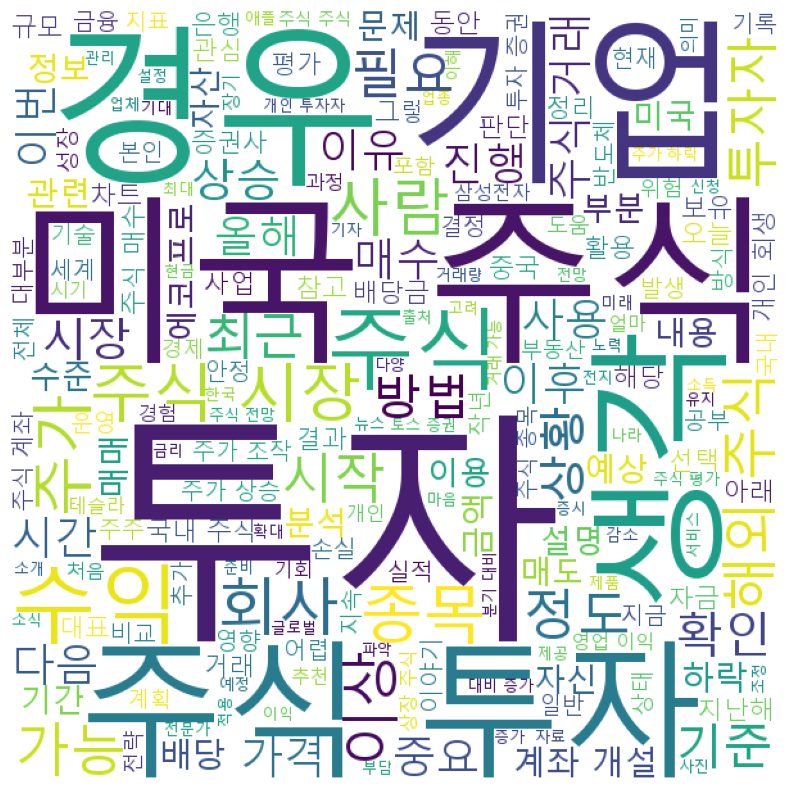

In [29]:
from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

## b. Similar document (tf-idf vector기준 cosine similarity)

- <span style = 'font-size:1.1em;line-height:2.0em'>주식</span>

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(stock['전처리 된 본문'])

In [7]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [8]:
cosine_sim[0]

array([1.        , 0.10365335, 0.27798787, ..., 0.01344669, 0.0188323 ,
       0.01631339])

In [28]:
title_to_index = {k:v for k,v in zip(stock['제목'], stock.index)}

In [29]:
title_to_index

{'비상장주식사기 피해회복을 하기위해서': 0,
 '주식 개인회생 빚 갚기 힘든 상태라면': 1,
 '주식투자사기 고소 처벌은': 2,
 '주식 개인회생 채무탕감 가능한 부분인지': 3,
 '주식투자사기 고소 마주한 상황이라면': 4,
 '까다로운 개인회생 주식 기각사유 없도록': 5,
 '주식 빚 도박빚 채무조정이 가능한 신용회복 제도': 6,
 '도박빚 개인회생 비트코인 주식 빚 같은 관점에서': 7,
 '개인파산면책 도박 빚 주식 빚 포함된다니': 8,
 '주식투자사기 피해를 입었을 때는': 9,
 '최근 주식시장을 보면서...(ft.SG사태)': 10,
 '주식공부 및 주식정보 얻는 방법': 11,
 '숙향의 주식투자 이야기 :: 매수 보유 매도': 12,
 '4월 주식 매매 : 애플, VOO, 차이나 전기차 (ft.장기투자 2년... ': 13,
 '임창정 주식 빚 60억 차압 : 주가조작 피해 주장': 14,
 '임창정 주식 작전세력 주식방송 출연 논란이유': 15,
 '주식 코인 개인회생 투자실패 빚 처리될까': 16,
 '비상장주식사기 위기의 순간이라면': 17,
 '직장인 주식투자 방법론 단상 (feat. 숙향님)': 18,
 '미국주식, 상승 or 하락?': 19,
 '무리한 도박 성 주식 투자로 빚 늘었다면': 20,
 '주식 배당금,고배당주 순위 한번 알아봅니다. (배당 2만원)': 21,
 '100배 주식': 22,
 '미국주식 배당주로 다시 시작하기 SCHD / JEPI / QLD': 23,
 '미성년자 주식계좌개설, 이제 비대면으로도 가능해요': 24,
 '주식 신용거래의 허와 실': 25,
 '미국 주식 식품 관련주 포스트 홀딩스 주식 (POST)': 26,
 '주식말고 기업을 사라.': 27,
 '주식이란? 기초 투자 공부 시작하기, 주식 입문 (1)': 28,
 '연금저축계좌 2023.4.26 - 미국 주식 S\\&P500 적립': 29,
 '삼성 바이오로직스, KT\\&G 주식': 30,
 '[주식기록1] 현대모비스': 31,

In [30]:
index_to_title = {v:k for k,v in title_to_index.items()}

In [32]:
index_to_title

{0: '비상장주식사기 피해회복을 하기위해서',
 1: '주식 개인회생 빚 갚기 힘든 상태라면',
 2: '주식투자사기 고소 처벌은',
 3: '주식 개인회생 채무탕감 가능한 부분인지',
 4: '주식투자사기 고소 마주한 상황이라면',
 5: '까다로운 개인회생 주식 기각사유 없도록',
 6: '주식 빚 도박빚 채무조정이 가능한 신용회복 제도',
 7: '도박빚 개인회생 비트코인 주식 빚 같은 관점에서',
 8: '개인파산면책 도박 빚 주식 빚 포함된다니',
 9: '주식투자사기 피해를 입었을 때는',
 10: '최근 주식시장을 보면서...(ft.SG사태)',
 11: '주식공부 및 주식정보 얻는 방법',
 12: '숙향의 주식투자 이야기 :: 매수 보유 매도',
 13: '4월 주식 매매 : 애플, VOO, 차이나 전기차 (ft.장기투자 2년... ',
 14: '임창정 주식 빚 60억 차압 : 주가조작 피해 주장',
 15: '임창정 주식 작전세력 주식방송 출연 논란이유',
 16: '주식 코인 개인회생 투자실패 빚 처리될까',
 17: '비상장주식사기 위기의 순간이라면',
 18: '직장인 주식투자 방법론 단상 (feat. 숙향님)',
 19: '미국주식, 상승 or 하락?',
 20: '무리한 도박 성 주식 투자로 빚 늘었다면',
 21: '주식 배당금,고배당주 순위 한번 알아봅니다. (배당 2만원)',
 22: '100배 주식',
 23: '미국주식 배당주로 다시 시작하기 SCHD / JEPI / QLD',
 24: '미성년자 주식계좌개설, 이제 비대면으로도 가능해요',
 25: '주식 신용거래의 허와 실',
 26: '미국 주식 식품 관련주 포스트 홀딩스 주식 (POST)',
 27: '주식말고 기업을 사라.',
 28: '주식이란? 기초 투자 공부 시작하기, 주식 입문 (1)',
 29: '연금저축계좌 2023.4.26 - 미국 주식 S\\&P500 적립',
 30: '삼성 바이오로직스, KT\\&G 주식',
 31: '[주식기록1] 현대모비스',

In [45]:
title_to_link = {k:v for k,v in zip(stock['제목'], stock['링크'])}

In [46]:
title_to_link

{'비상장주식사기 피해회복을 하기위해서': 'https://blog.naver.com/badugi721/223084278987',
 '주식 개인회생 빚 갚기 힘든 상태라면': 'https://blog.naver.com/yoma0721/223081268277',
 '주식투자사기 고소 처벌은': 'https://blog.naver.com/labmusic/223084491198',
 '주식 개인회생 채무탕감 가능한 부분인지': 'https://blog.naver.com/yoonz486/223066885901',
 '주식투자사기 고소 마주한 상황이라면': 'https://blog.naver.com/baramic/223039476153',
 '까다로운 개인회생 주식 기각사유 없도록': 'https://blog.naver.com/plit/223085327820',
 '주식 빚 도박빚 채무조정이 가능한 신용회복 제도': 'https://blog.naver.com/emeth7100/223060019321',
 '도박빚 개인회생 비트코인 주식 빚 같은 관점에서': 'https://blog.naver.com/indiemediasam/223088331728',
 '개인파산면책 도박 빚 주식 빚 포함된다니': 'https://blog.naver.com/pellie/223077459219',
 '주식투자사기 피해를 입었을 때는': 'https://blog.naver.com/100chajin/223065432211',
 '최근 주식시장을 보면서...(ft.SG사태)': 'https://blog.naver.com/xuenxu/223085738020',
 '주식공부 및 주식정보 얻는 방법': 'https://blog.naver.com/mellongi123/223080239743',
 '숙향의 주식투자 이야기 :: 매수 보유 매도': 'https://blog.naver.com/seonghak/223082661080',
 '4월 주식 매매 : 애플, VOO, 차이나 전기차 (ft.장기투자 2

In [17]:
list(enumerate(cosine_sim[0]))

[(0, 1.0),
 (1, 0.10365334954922398),
 (2, 0.27798786646442836),
 (3, 0.12108727046307867),
 (4, 0.19555144844213518),
 (5, 0.06272480360176064),
 (6, 0.17620520793209685),
 (7, 0.09798726870850243),
 (8, 0.08157380029685926),
 (9, 0.4468591643840844),
 (10, 0.06825096507803324),
 (11, 0.05839624804347285),
 (12, 0.06528796136612451),
 (13, 0.030823761539906333),
 (14, 0.042669678024094014),
 (15, 0.10087694238059976),
 (16, 0.0874875666366989),
 (17, 0.3561865405785495),
 (18, 0.09467593561977201),
 (19, 0.06695183748599816),
 (20, 0.057142064906246036),
 (21, 0.04104038113204188),
 (22, 0.0750949357466347),
 (23, 0.07321445237389522),
 (24, 0.07621358492677374),
 (25, 0.03636162617908604),
 (26, 0.02819768697511539),
 (27, 0.05923450304135637),
 (28, 0.11255594332476794),
 (29, 0.041233644556599836),
 (30, 0.014946358733694518),
 (31, 0.06747486973663903),
 (32, 0.01547570010930564),
 (33, 0.06614490423959404),
 (34, 0.02069567969797966),
 (35, 0.11086998563153395),
 (36, 0.065847073

In [85]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [86]:
result = get_top10_similarity('비상장주식사기 피해회복을 하기위해서', cosine_sim)

[396, 112, 517, 570, 9, 46, 567, 17, 475, 471]


In [87]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [88]:
doc_similarity_df

제목                                                링크
0    비상장주식사기 고소 진행을 바란다면     https://blog.naver.com/badugi721/222989475564
1   비상장주식사기 고소 피해 회복이 먼저     https://blog.naver.com/badugi721/223031515406
2     비상장주식 사기 고소 피해 보전은    https://blog.naver.com/chihun9493/223043277175
3      비상장주식사기 고소 고려중이라면    https://blog.naver.com/stjeronimo/223043913512
4      주식투자사기 피해를 입었을 때는     https://blog.naver.com/100chajin/223065432211
5  비상장주식사기 고소하기 위해서는 이렇게  https://blog.naver.com/designersiun/223065274027
6     주식 리딩방의 기상천회한 사기수법      https://blog.naver.com/thyoon55/223058025566
7      비상장주식사기 위기의 순간이라면       https://blog.naver.com/baramic/223043056212
8   장외주식사기 투자금 반환을 위해서는!      https://blog.naver.com/edith_05/223056942019
9      장외주식사기 고소 도움을 받아서       https://blog.naver.com/baramic/223045163429

In [43]:
stock['본문'][0]

"비상장주식사기 피해회복을 하기위해서  비상장주식사기로 인해서 고소 진행을 고려하고 있는 분들이 많이 있다고 하였습니다. 이 때는 주로 가볍게 생각하고 넘기기도 하지만 생각보다 더 심한 케이스도 많이 있기 때문에 체계적이고 탄탄한 법적 절차의 준비가 필요하다고 강조하고 있다고 하였는데요. 이러한 주식사기의 케이스는 보통 타인이 자신에게 주식투자를 적극적으로 권하고 투자를 통해서 큰 수익을 낼 수 있다며 유혹하면서 이에 넘어가게 되어 발생하는 사기 사건이 많다고 할 수 있다고 하였습니다.아무래도 쉽게 돈을 벌고싶은 욕심과 돈을 벌게 해주겠다며 선뜻 선의를 베풀고 덥석 믿는 것이 문제가 되기도 한다고 하였습니다. 판데믹 이슈가 발생한 이후로 경제가 어려워지고 돈을 버는 것이 어려워진 만큼 투자에 대한 사람들의 갈망이 더욱 커지고 있기도 하였는데요. 이런 비상장주식사기 등으로 인해 피해를 입는 일이 없도록 주의해야한다고 하였습니다. 비상장주식사기 당했다면 이것만 알아두세요500원짜리 주식, 50배 뻥튀기 당했습니까? '연말에는 상장이 된다는데?' 네, 거짓입니다. 그럴듯...blog.naver.com  비상장인 상태에서 이루어진 비상장주식사기이런 사기 수법의 경우 여러 가지 수법으로 접근을 하고 사기를 진행하게 된다고 하였습니다. 한 사례를 통해 살펴보도록 하였습니다. 퇴근 후 쉬고 있던 중 갑자기 한 통의 전화가 걸려오게 되었다고 하였습니다. A씨에게 전화를 건 이 사람은 어떤 기술이 미래에 전망이 밝다며 마치 중요한 정보를 줄 것 처럼 A씨를 현혹하게 되었다고 하였는데요.현재 상장이 확정된 곳이고 공모가가 얼마라며 구체적으로 내용을 전하였습니다. 이에 지금 투자를 하면 1주에 얼마로 살 수 있는 기회가 주어진다고 유혹하게 되었다고 하였는데요. A씨는 처음에는 의심하지만 이내 전화를 건 사람으로 부터 듣는 이야기에 의해서 의심을 거두어들이게 되었다고 하였습니다. 전화를 건 사람은 먼저 해당 기술이 정말 전망이 좋고 확정이나 다름 없으나 특례 심사 과정에서 소액 주

In [44]:
stock['본문'][396]

'비상장주식사기 고소 진행을 바란다면  혼자는 하지못한 일 여러사람과 함께 한다면 가능할수도 있습니다. 사람은 누구나 혼자서는 살아갈 수 없습니다.서로 잘하는 분야가 따로 있기때문에 내가 알지 못하는 부분에대해서는 도움을 받으시기 바랍니다.  내 돈을 불려주겠다는 사람너무 쉽게 돈을 벌려고 했던 나비상장주식사기가 보통 이렇습니다. 나에게 누군가 접근해 투자를 하라고 권유하고 이것으로 큰 돈을 벌 수 있다라는 유혹에 홀랑 넘어가버려서 때늦은 후회를 해봤자 내가 투자한것은 다시 돌아오지않습니다. 그리고 깨달았다고 이야기하죠. 쉽게 벌려고하면 안된다 그리고 나에게 그런 선의를 베푸는 사람은 없다코로나이후로 정말 말도안되는 주식시장이 생겨나면서 너도나도 계좌를 만들고 이 시장에 뛰어들게됩니다. 옆에서 투자를 통해 대박이나서 부자가되는것을 보고 있으니 나도 가능하지않을까싶은 생각을 하고 있던 찰나를 이용해 비상장주식 투자사기가 기승을 부리고 있습니다.  달콤한 투자 권유전화그것이 불행의 씨앗이었다내부자 정보라며 아직 상장이 되지않았지만 곧 된다고 지금 사면 수십배를 벌 수 있다며 피해자들을 유혹합니다. 그래서 그동안 모은 전재산을 투자했는데 막상 상장 당일에는 정보를 준 사람은 잠수를 타게되는 것이 비상장주식사기입니다. 🔔 어떤수법으로 접근하는지 한가지 사례를 살펴볼까요?퇴근 후에 지친몸을 달래고 있는데 한통의 전화가 옵니다. 전화를 건 사람은 이야기합니다. 어떤어떤 기술이 미래에 좋다라면서 한가지 정보를 준다고합니다. 현재 상장이 확정된 곳인데 공모가는 현재 4만원이다 그러나 지금 1주당 1만원에 살 수 있는 기회를 특별히 드리겠다. 하지만 이런 좋은정보를 나한테 왜줘? 라고 생각하는 사이 전화를 건 사람은 두가지를 이야기 합니다.1. 정말 좋은 기술이고 이제 확정이나 다름없는 상황이지만 특례심사를 하기위해서는 소액주주 비율이 25%는 되어야한다.2. 그런데 그럴듯한 사정을 이야기하며 일반대중을 상대로 기업설명회를 바로 개최를 할 수 없다 그래서 전화로 설명을 드리고

## 채권 키워드에 대해 전처리 및 분석 진행(위와 코드 동일)

- <span style = 'font-size:1.1em;line-height:2.0em'>채권</span>

In [1]:
import pandas as pd

bond = pd.read_csv('text_data_bond.csv')

In [2]:
bond['본문'] = bond['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [4]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
bond['본문'] = bond['본문'].apply(correct_spacing)

# 결과 출력
print(bond['본문'])

0       쌓인 부채를 털어내지 못하면 불법 채권추심까지 시 달릴 가능성이 있다고 설명하였습니...
1       불법 채권추심 빚 독촉 채무자 대리인 제도 하나로 해결될까 올해 3월 20일부터 1...
2       불법 채권추심 조력자의 도움으로 4대 보험 가입자가 아니어도 되고 일용직도 가능하니...
3       물가와 금리가 고공행진 하면서 은행권에서 대출이 어려워진 분들이 많다고 하였습니다....
4       불법 채권추심 혼자 고민하기 보다는 채무이행이 되지 않았을 때에는 빌려가는 사람을 ...
                              ...                        
1574    (부산=연합뉴스) 조정호 기자 = BNK투자증권은 15일부터 제공하는 '중개형 IS...
1575    경상북도는 안정적인 외상거래를 지원하기 위해 지역 중소기업에 매출채권보험료를 최대 ...
1576    외국인 투자자들이 지난달 국내에서 상장 주식과 채권을 6조 원 가까이 사들인 것으로...
1577    TDF 순자산 중 90% 이상이 연금 클래스 … 퇴직연금에만 8.1 조 들어가 지난...
1578    한국거래소는 다음달 14일 끝날 예정이던 사회 책임투자 채권(SRI 채권) 상장수수...
Name: 본문, Length: 1579, dtype: object


In [59]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
bond['전처리 된 본문'] = bond['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
bond = bond[['제목', '본문', '전처리 된 본문', '링크']]

In [60]:
bond.head()

제목  \
0        채무자대리인제도 불법채권추심 막는 대응책   
1  불법채권추심 빚독촉 채무자대리인제도 하나로 해결될까   
2              불법채권추심 조력자의 도움으로   
3    불법채권추심 걱정될 때 채무자대리인제도 해답일까   
4            불법채권추심 혼자 고민하기 보다는   

                                                  본문  \
0  쌓인 부채를 털어내지 못하면 불법 채권추심까지 시 달릴 가능성이 있다고 설명하였습니...   
1  불법 채권추심 빚 독촉 채무자 대리인 제도 하나로 해결될까 올해 3월 20일부터 1...   
2  불법 채권추심 조력자의 도움으로 4대 보험 가입자가 아니어도 되고 일용직도 가능하니...   
3  물가와 금리가 고공행진 하면서 은행권에서 대출이 어려워진 분들이 많다고 하였습니다....   
4  불법 채권추심 혼자 고민하기 보다는 채무이행이 되지 않았을 때에는 빌려가는 사람을 ...   

                                            전처리 된 본문  \
0  부채 불법 채권 추심 가능 설명 행위 채권자 채무자 생활 보장 채무자 대리인 제도 ...   
1  불법 채권 추심 독촉 채무자 대리인 제도 해결 올해 불법 채권 추심 근절 특별 단속...   
2  불법 채권 추심 조력자 도움 보험 가입자 일용직 가능 평균치 소득 보충 가능 새벽 ...   
3  물가 금리 고공 행진 은행 대출 금융 자금 융통 법사 금융 원금 이자 상환 무분별 ...   
4  불법 채권 추심 혼자 고민 이행 사람 신뢰 신용 채권자 강제 채무자 추심 절차 테두...   

                                             링크  
0    https://blog.naver.com/afmadl/223097330206  
1   https://blog.naver.com/styoooo/223097652411  
2  https://blog.naver.com/wilsjins/223097970386  
3   https://blog.naver.com/soomeco/223091464920  
4    https://blog.naver.com/proger/223096488425

In [61]:
combined_text = ' '.join(bond['전처리 된 본문'].astype(str).values)

In [9]:
# wordcloud에서 한글을 사용할 수 있도록 설정하기
font_path = 'C:\\Users\\user\\anaconda3\\envs\\text\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\malgun.ttf'

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

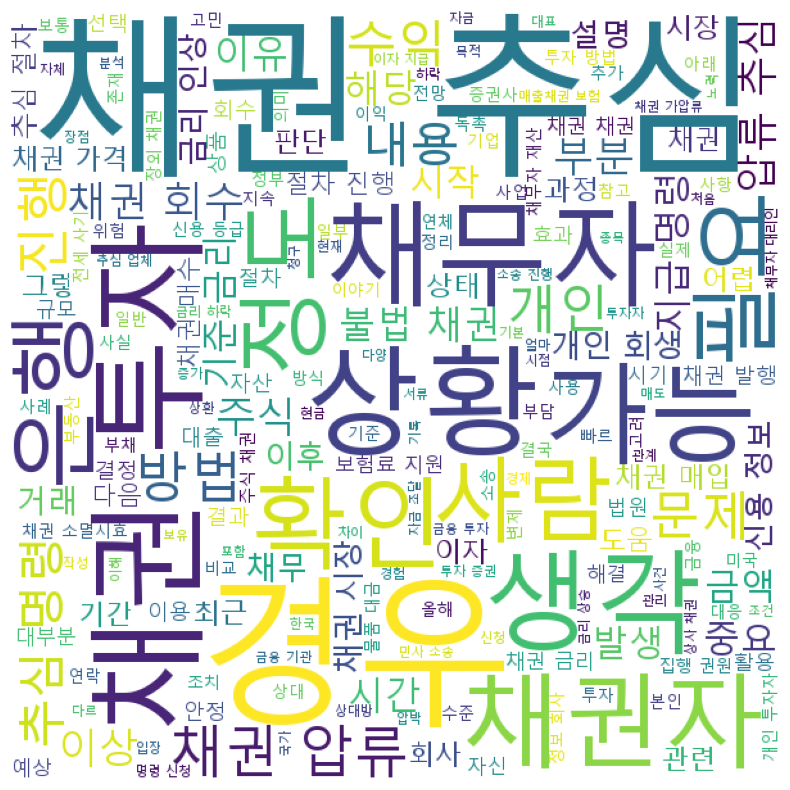

In [64]:
from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

In [65]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [66]:
# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(bond['전처리 된 본문'])

In [67]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [68]:
title_to_index = {k:v for k,v in zip(bond['제목'], bond.index)}

In [69]:
index_to_title = {v:k for k,v in title_to_index.items()}

In [70]:
title_to_link = {k:v for k,v in zip(bond['제목'], bond['링크'])}

In [71]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [72]:
result = get_top10_similarity('불법채권추심 혼자 고민하기 보다는', cosine_sim)

[41, 51, 45, 137, 37, 123, 692, 46, 291, 458]


In [73]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [74]:
doc_similarity_df

제목  \
0            불법채권추심 위험을 직면해 있다면   
1  불법채권추심 합법 차이와 개인회생 금지명령 활용하기   
2             불법채권추심 불이익 당하지 말고   
3   채권압류 및 추심명령 채권추심절차 근본적인 대응은   
4             불법채권추심 당당하게 대응하려면   
5      불법채권추심 뜻 이해하고 절차 시작되기 전에   
6        불법채권추심 정확히 알고 셀프 대처하는법   
7    채권압류 및 추심명령 합법적인 대응 어떻게 해야   
8       불법채권추심 효과적으로 대응하기 위한 방법   
9    채권추심 절차 뜻 채권 추심 대응 방법 알아보면   

                                                 링크  
0    https://blog.naver.com/djawjdgus3/223063457621  
1       https://blog.naver.com/nhj0122/223066373707  
2  https://blog.naver.com/antifreezing/223046126282  
3    https://blog.naver.com/djawjdgus3/223008150322  
4       https://blog.naver.com/edu123-/223086945724  
5     https://blog.naver.com/emeth7100/223026365452  
6      https://blog.naver.com/svyr4825/223088112474  
7      https://blog.naver.com/yoma0721/223067351177  
8     https://blog.naver.com/tnkbody22/223056138933  
9    https://blog.naver.com/doeltmxm45/223097534955

In [75]:
bond['본문'][4]

'불법 채권추심 혼자 고민하기 보다는 채무이행이 되지 않았을 때에는 빌려가는 사람을 믿고 그 빚을 내어준 것이 기 때문에 신뢰를 저버리게 되어 신용이 내려가게 되며 받아야 할 것을 다시 돌려받지 못한 채권자는 강제적으로라도 채무자가 가진 것을 가져가는 등의 추심을 진행할 수 있게 된다고 하였습니다. 다만 이러한 절차는 법의 테두리 안에서 이루어져야 하는데,  대부업체나 사채를 통하여 빚을 내었다면 불법채권추심에 시 달릴 수도 있다고 하였습니다. 물론, 대부업체가 반드시 이런 행위를 하는 것은 아니지만 은행에서 진행되는 추심보다는 이 금융권에 해당하는 채권자가 더 위법행위를 하기 쉽다고 하였습니다. 또한, 대부업체를 통해 빚을 내 지 않았어도 은행의 빚이더라도 오랜 기간 갚지 않는다면 추심 전문업체로 채권이 넘어 갈 수 있는데, 처음에는 추심 팀으로 채권이 이 관 되겠지만 계속해서 변제가 이루어지지 않을 시 추심 전문업체로 넘어가기 때문이라 하였습니다. 하지만 빚을 갚지 않은 채무자의 입장에서는 모두 상당한 부담임은 틀림 없을 것이라 하였습니다. 합법적으로 채무자의 재산을 압류하게 되는 절차들은 여러 가지가 있는데, 통장만을 압류하게 되더라도 현금을 수 중에 쥐고 있었 다면 그나마 다행이겠지만 통 장 안에 예금이 본인 재산에 전부라면 당장 쓸 돈이 없어 생계 유지가 불가할 수 있고 당연히 금융생활에도 차질을 빚을 수 있다고 하였습니다. 더불어, 이러한 금전의 압류는 통 장 뿐 아니라 아예 회사 측에 급여 자체를 압류하게 될 수 있는데 이렇게 된다면 회사에서 채무 사실을 어 쩔 수 없이 알게 되고 신용에 문제가 있는 사람으로  판단이 되어 실직을 하게 되는 등 불법이 아니더라도 채무자에게 부담이 되는 일이라 하였습니다. 또한, 유체동산을 압류 하는 과정에 있어서는 집행관과 채권자 측의 사람들이 강제 개문을 하고 집 안에 있는 물건들에 압류를 할 것들이라고 빨간 딱지를 붙이게 되는데, 이는 살림살이마저 빼앗긴다는 압박만이 아니라 주변 이웃들이 알게 되어 상당한 부담

In [76]:
bond['본문'][41]

'불법 채권추심 위험을 직면해 있다면 자본이 있어야 생활이 가능한 지금의 경제 사회에서 빚이 있다는 건 그만큼의 금액이 마이너스를 기록하는 것으로 가진 것이 없는 수준을 넘어 지금 가진 것도 본인만의 소유가 아니라는 점 때문에 빚이 주는 부담감은 상당히 크다고 하였습니다. 나아가 빚을 갚지 못했을 때에는 그 부담감이 더 늘게 될 텐데, 빚을 갚지 않아 여러  불이익을 받을 것이고 그 중에서 채권자의 불법채권추심은 얼른 빚을 갚으라는 독촉부터 시작해 재산을 압류 당할 수도 있기 때문이라 하였습니다. 만 약 채권자가 불쑥 방문하여 현재 채권을 만족시키기 위해서 아무런 절차를 밟지 않고 채무자가 가지고 있는 것을 대뜸 가져가 버리게 되면 불법 채권추심에 해당하게 되는데, 이를 알면서도 어찌할 방법이 없다고 생각하고  혹은 위법인지 모르고 있는 경우도 있을 수 있다고 하였습니다. 물론, 은행에서 빌린 돈, 카드 대금 등 대형 채권 기관에서 빚을 갚지 않았다고 그 기관 관계자들이 이런 일을 저지를 수 있다는 얘기는 아니라 고 하였습니다. 채무 이행이 계속 되지 않을 시에는 제도권 내 신용정보 회사로, 시간이 지나면 중소 규모 회사, 여기서 또 지나게 되면 대부업체까지 채권 이 넘어가게 되는데 이는 처음에 은행을 통해서 빌리던 것이 2금융권으로 떨어지게 되고 추후에는 대부업체에서 돈을 빌리게 되는 것과 비슷하게 흘러간다고 보시면 된다고 하였습니다. 자신이 이미 채무 이행을 제대로 하지 못한 지 시간이 꽤 지나게 되어 통장도 압류 당하고 그럼에도 빚을 갚지 않았다면 이제는 대부업체 쪽에서 불법채권추심추심을 받을 수도 있는  것이라 하였습니다. 그렇기 때문에 대부업체에서 불법채권추심으로 채무자를 괴롭힌다고 하더라도 빚을 갚지 않은 결과 라 어쩔 수 없다고 생각하는 것인데 이 생각은 틀렸다고 하였습니다. 채무자 또한 사람으로서 기본적인 권리가 있어 채권자 쪽에서 권리를 남용하거나 불법적인 일을 하지 못하도록 채권의 공정한 추심에 관한 법률이 있기 때문에 빚을 갚지 못했다고 해

## 적금 키워드에 대해 전처리 및 분석 진행(위와 코드 동일)

In [31]:
import pandas as pd

save = pd.read_csv('text_data_savings.csv')

In [32]:
save['본문'] = save['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [33]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
save['본문'] = save['본문'].apply(correct_spacing)

# 결과 출력
print(save['본문'])

0       청년희망적금은 청년들이 강제로라도 목돈을 모을 수 있도록 2년 만기 적금을 들게 해...
1       제가 사회생활을 처음 시작할 때만 하더라도 많은 선배님들이 버티는 자가 결국은 승자...
2       한국은행의 기준금리 동결로 시 중은행의 예금 금리가 낮아지며 관련 상품의 인기가 낮...
3       신한은행 고객센터에 다른 볼 일이 있어 전화했다가 적금 상품 문의를 했더니 아름다운...
4       청년희망적금 청년도 약계좌 중복 불가 둘 중 하나를 택해야 한다면 ? 청년도 약계좌...
                              ...                        
1328    (엑스포츠뉴스 윤현지 기자) 김경필 이 저축을 방해하는 '저축 오적'을 설명했다.1...
1329    [텐아시아=태유나 기자] 사진=MBC '세치혀' 방송 화면. 김경필 이 전현무에게 ...
1330    12개월 만기 적금...시중은행 최고 연 4.3%-저축은행 최고 연 4.8% ◆…시...
1331    [상생 금융시대] ① 금융지주 '대형 상생안' 잇따라 발표이자 감면 및 우대금리 제...
1332    전직 대통령 고(故) 전두환 씨의 손자 전 우원 씨가 31일 오전 광주 북구 운정동...
Name: 본문, Length: 1333, dtype: object


In [38]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
save['전처리 된 본문'] = save['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
save = save[['제목', '본문', '전처리 된 본문', '링크']]

In [49]:
save.tail()

제목  \
1328      김경필, "지금은 주식·코인 NO" 콕 집은 투자 시기는 언제? (세치혀)[종합]   
1329        [종합] 전현무, 제대로 혼쭐났다…"재벌 회장도 아니잖아" 팩폭 ('세치혀')   
1330           시중은행 정기예금 금리 최고 연 3.75%...저축은행 최고 연 4.5%   
1331                        170만 대출자 웃게 한 금융지주 ‘상생 보따리’   
1332  [3/31 데일리안 퇴근길뉴스] "할아버지가 5·18 학살 주범" 전두환 손자, 무...   

                                                     본문  \
1328  (엑스포츠뉴스 윤현지 기자) 김경필 이 저축을 방해하는 '저축 오적'을 설명했다.1...   
1329  [텐아시아=태유나 기자] 사진=MBC '세치혀' 방송 화면. 김경필 이 전현무에게 ...   
1330  12개월 만기 적금...시중은행 최고 연 4.3%-저축은행 최고 연 4.8% ◆…시...   
1331  [상생 금융시대] ① 금융지주 '대형 상생안' 잇따라 발표이자 감면 및 우대금리 제...   
1332  전직 대통령 고(故) 전두환 씨의 손자 전 우원 씨가 31일 오전 광주 북구 운정동...   

                                               전처리 된 본문  \
1328  스포츠 뉴스 윤현지 기자 김경필 저축 방해 저축 오적 설명 오후 방송 예능 프로그램...   
1329  아시아 태유 기자 사진 세치 방송 화면 김경필 전현무 재벌 회장 일침 방송 예능 혓...   
1330  만기 적금 시중 은행 최고 저축 은행 최고 시중 은행 정기예금 금리 기준 거치 자료...   
1331  상생 금융 시대 금융 지주 대형 상생 발표 감면 우대금리 제공 국민 신뢰 회복 지난...   
1332  전직 대통령 전두환 손자 우원 오전 광주 북구 운정동 국립 민주 묘지 유가족 김길자...   

                                                     링크  
1328  https://n.news.naver.com/mnews/article/311/000...  
1329  https://n.news.naver.com/mnews/article/312/000...  
1330  https://n.news.naver.com/mnews/article/123/000...  
1331  https://n.news.naver.com/mnews/article/243/000...  
1332  https://n.news.naver.com/mnews/article/119/000...

In [40]:
combined_text = ' '.join(save['전처리 된 본문'].astype(str).values)

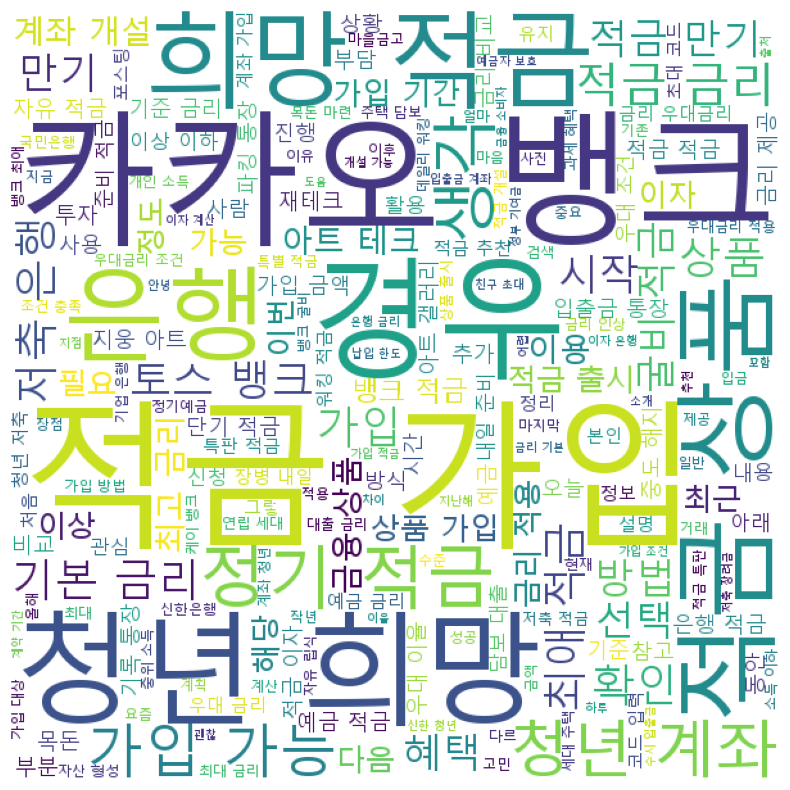

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(save['전처리 된 본문'])

In [43]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [44]:
title_to_index = {k:v for k,v in zip(save['제목'], save.index)}
index_to_title = {v:k for k,v in title_to_index.items()}
title_to_link = {k:v for k,v in zip(save['제목'], save['링크'])}

In [45]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [51]:
result = get_top10_similarity('170만 대출자 웃게 한 금융지주 ‘상생 보따리’', cosine_sim)

[1275, 1249, 1216, 1228, 1144, 1015, 1145, 1181, 1210, 1235]


In [52]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [53]:
doc_similarity_df

제목  \
0            시중은행, 달아오른 ‘상생경쟁’…“누가누가 착한금융 잘하나”   
1  우리금융 임종룡 ‘상생’ 외치며 대출금리 내리더니… 슬그머니 적금금리도 ...   
2                  하나금융, 다자녀가구 대상 '최고 연 8%' 적금   
3            하나금융 "다자녀 우대 ‘8% 적금’ 출시, 대출금리 인하"   
4          하나금융, 다자녀 상생금융 추진…'연 8%' 적금·대출금리 감면   
5                "적금들면 금리 깎아줘"…배보다 배꼽 더 큰 부수거래   
6      연 8% 적금·대출금리 감면...다자녀 우대 상생금융 추진하는 하나금융   
7             연 8% 주는 적금 아직 있다…하나은행, 다자녀가구에 쏜다   
8                  하나금융, 최고 연 8% 적금 등 다자녀 맞춤상품   
9          하나은행, 다자녀 우대 '연 8%' 적금 출시…대출 금리 인하도   

                                                  링크  
0  https://n.news.naver.com/mnews/article/018/000...  
1  https://n.news.naver.com/mnews/article/366/000...  
2  https://n.news.naver.com/mnews/article/015/000...  
3  https://n.news.naver.com/mnews/article/469/000...  
4  https://n.news.naver.com/mnews/article/001/001...  
5  https://n.news.naver.com/mnews/article/092/000...  
6  https://n.news.naver.com/mnews/article/024/000...  
7  https://n.news.naver.com/mnews/article/018/000...  
8  https://n.news.naver.com/mnews/article/029/000...  
9  https://n.news.naver.com/mnews/article/119/000...

In [57]:
save['본문'][1331]

"[상생 금융시대] ① 금융지주 '대형 상생안' 잇따라 발표이자 감면 및 우대금리 제공…“국민 신뢰 회복하자” 지난달 9일 서울 여의도 국민은행 본점에서 금감원-KB국민은행 상생금융 확대를 위한 금융소비자 현장 간담회가 진행되고 있다. [사진 연합뉴스][이코노미스트 김정훈 기자] 올해 들어 금융사들이 이자 감면, 중소기업, 자영업자 지원책 등 ‘상생금융안 ’을 대 거 내놓고 있다. 규모도 크다. 상생 안들을 보면 기본적으로 이자 감면, 금융지원 규모가 수 천억원대다. 또 자영업자, 중소기업을 위한 맞춤형 지원사업도 확대됐다. 이 정도면 진짜 ‘보따리’를 푼 셈이다. 여기에 그치지 않고 금융지주 회장들은 올해 주력 사업 중 하나로 ‘사회 환원’을 외치며 관련 사업을 꾸준히 추진할 기세다.170만명에 3300억 ‘ 이자 감면’ 금융권 상생 바람의 화두를 튼 사람은 이복현 금융감독원장이다. 그는 지난 2월부터 하나은행을 시작으로 BNK 부산은행, KB국민은행, 신한은행, DGB대구은행을 잇따라 방문해 상생 금융 간담회를 열었다. 금융사들도 ‘상생 보따리’를 풀기 시작했다. 은행들은 주택담보대출, 전세자금대출, 신용대출 기본 금리 인하와 함께 취약차주별 이자 감면, 중소기업  대출 금리 인하, 자영업자 금융지원 및 성장 컨설팅 등의 상생안을 내놨다. KB국민은행은 신용대출 0.5%p, 주담대와 전세자금 대출금리를 0.3%p 내린다. 신한은행도 주담대 0.4%p, 전세자금 0.3%p, 신용 0.4%p 금리를 인하한다. 하나은행은 비대면 주담대, 전세자금, 신용 대출 금리를 최대 0.5%p 내리고 우리은행도 주담대 최대 0.7% p, 전세자금 최대 0.6%p를 인하한다. 국내 은행권은 상대적으로 변동금리 대출 비중이 커 시장금리 상승에 따른 차주 부담이 다른 나라보다 큰 편이다. 실제 국내 주요 은행권 주담대 변동금리 비중은 67% 지만 미국은 15%에 불과 하다. 은행권 한 관계자는 “지난 몇 년간 기준금리가 꾸준히 오르며 서민들은 그 어느 때보다 이자로 시름해왔다”며

In [58]:
save['본문'][1275]

"하나은행, 다자녀 가구 적금에 대출 금리 감면까지 …상생 신호탄 우리은행, 소상공인 끌어안기…'연 최대 10%' 사장님 적금 ‘인기’ 국민은행, 업계 최초 2금융권 대환대출로 서민 돕는 희망사다리[이데일리 정두리 기자] 금융권의 ‘돈잔치’ 논란 이후 금융당국이 은행들에 사회적 책임을 연일 주문하는 가운데 주요 시 중은행들이 상생을 모토로 한 금융상품을 경쟁하듯 내 놓고 있다. 은행권에 불 붙은 상생 금융 경쟁으로 인해 더 많은 고객에게 혜택이 돌아갈지 주목된다. 사진=하나은행 10일 금융권에 따르면 하나은행은 이 달 말 2명 이상의 자녀를 양육하는 (양육 예정인) 부모를 위한 금융 신상품 ‘하나 아이키움 적금’을 출시한다. 이 적금은 1만원 이상 30만원 이하의 금액으로 가입이 가능한 1년 만기 적립식 예금으로, 기본금리  2.0%에 양육수당 수급 여부·자녀 수와 연령대 등을 통한 특별금리가 더해져 최고 연 8.0% 금리가 주어진다. 뿐만 아니라 하나은행은 주택담보대출과 전세자금대출을 신규 또는 기 한 연장하는 다자녀 가구 고객을 위해 최대 0.4%포인트의 대출 금리 감면도 계획하고 있다. 이는 초저출산·고령화 시대 극복을 위한 하나금융의 ‘HANA 인생 여정 프로젝트’의 첫 번 째 상생 금융 신호탄이다. 개인의 인생 여정 전체를 아우르는 맞춤형 상품 개발을 통해 금융이 저출산 문제에 기여하겠다는 야심찬 포부가 담겨 있다. 하나은행 관계자는 “결혼부터 임신, 일과 육아의 병행, 실버 케어 등 인생 여정 전반을 아우르는 종합적 지원 방안을 추가적으로 구상하고 있다”고 말했다. 지난 5일 임종룡 우리금융그룹 회장(왼쪽)과 정 연기 우리은행 중 소기 업그룹 부행장(오른쪽)이 소상공인 상생금융상품 ‘우리 사장님 활짝 핀 적금’ 1호 가입 고객과 기념촬영을 하고 있다. (사진=우리금융) 우리은행은 지난 5일 광장시장과 소상공인 지원을 확대하기 위한 ‘장금(場金)이’ 1호 결연을 맺은 데 이어 소상공인을 대상으로 한 ‘우리 사장님 활짝 핀 적금’을 출시했다. 이 상품은

## 예금 키워드에 대해 전처리 및 분석 진행(위와 코드 동일)

In [3]:
import pandas as pd

depo = pd.read_csv('text_data_deposit.csv')

In [4]:
depo['본문'] = depo['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [5]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
depo['본문'] = depo['본문'].apply(correct_spacing)

# 결과 출력
print(depo['본문'])

0       인생은 타이밍이 중요하다는 말처럼 언제 어떻게 무엇이 변화를 할지가 모르기 때문에 ...
1       베이비도 지 BABYDOGE 보유만 하면 받을 수 있는 에어드랍 수익률에 대하여 궁...
2       저축 좀 해보려고 하는데, 예금? 적금 ? CMA ? 파킹 통장 ?요즘에는 뭐가 좋...
3       안녕하세요.법무법인 테헤란 상속 전담센터입니다. 아무리 가까웠던 가족이라 하더라도,...
4       전체 이미지 클릭 시 홈페이지로 이동합니다. 대부분의 사람들이 적금보다는 조금 더 ...
                              ...                        
1554    NH농협은행(은행장 이석용)은 최근 농협은행 전남 순천시지부에서 ‘도시가 정원이 되...
1555                                             [KBS 부산]
1556    [서울=뉴시스] ◇임원 선임 ▲이사 문형욱 ▶ 네이버에서 뉴시스 구독하기▶ K-A ...
1557    금융업권마다 부실 위험도 달라 “천편일률적 적용 무리”정치권·금융당국 신중론 확산 ...
1558    3월 예금 잔액 806조 2295억원 금리 하락 영향, 대안 투자처로 이동지난달 주...
Name: 본문, Length: 1559, dtype: object


In [6]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
depo['전처리 된 본문'] = depo['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
depo = depo[['제목', '본문', '전처리 된 본문', '링크']]

In [17]:
depo.tail()

제목  \
1554        농협은행 “순천만예금으로 국제정원박람회 성공 기원”   
1555         부산은행, 1조 원 한도 ‘가을야구정기예금’ 출시   
1556                          [인사]예금보험공사   
1557  예금보호한도 1억 상향 두고 동상이몽…“업권별 차등 적용해야”   
1558   “시중은행도 불안하다?”...5대銀 정기예금 잔액 10조 ↓   

                                                     본문  \
1554  NH농협은행(은행장 이석용)은 최근 농협은행 전남 순천시지부에서 ‘도시가 정원이 되...   
1555                                           [KBS 부산]   
1556  [서울=뉴시스] ◇임원 선임 ▲이사 문형욱 ▶ 네이버에서 뉴시스 구독하기▶ K-A ...   
1557  금융업권마다 부실 위험도 달라 “천편일률적 적용 무리”정치권·금융당국 신중론 확산 ...   
1558  3월 예금 잔액 806조 2295억원 금리 하락 영향, 대안 투자처로 이동지난달 주...   

                                               전처리 된 본문  \
1554  농협 은행 은행장 이석용 최근 농협 은행 전남 순천시 지부 도시 정원 순천 예금 가...   
1555                                                 부산   
1556      서울 뉴시스 임원 선임 이사 문형욱 네이버 뉴시스 구독 유명 미술 작품 가격 공개   
1557  금융업 위험 천편일률 적용 무리 정치 금융 당국 신중 확산 실리콘밸리 뱅크 파산 사...   
1558  예금 잔액 금리 하락 영향 대안 투자처 이동 지난달 주요 은행 정기예금 잔액 가량 ...   

                                                     링크  
1554  https://n.news.naver.com/mnews/article/662/000...  
1555  https://n.news.naver.com/mnews/article/056/001...  
1556  https://n.news.naver.com/mnews/article/003/001...  
1557  https://n.news.naver.com/mnews/article/277/000...  
1558  https://n.news.naver.com/mnews/article/016/000...

In [7]:
combined_text = ' '.join(depo['전처리 된 본문'].astype(str).values)

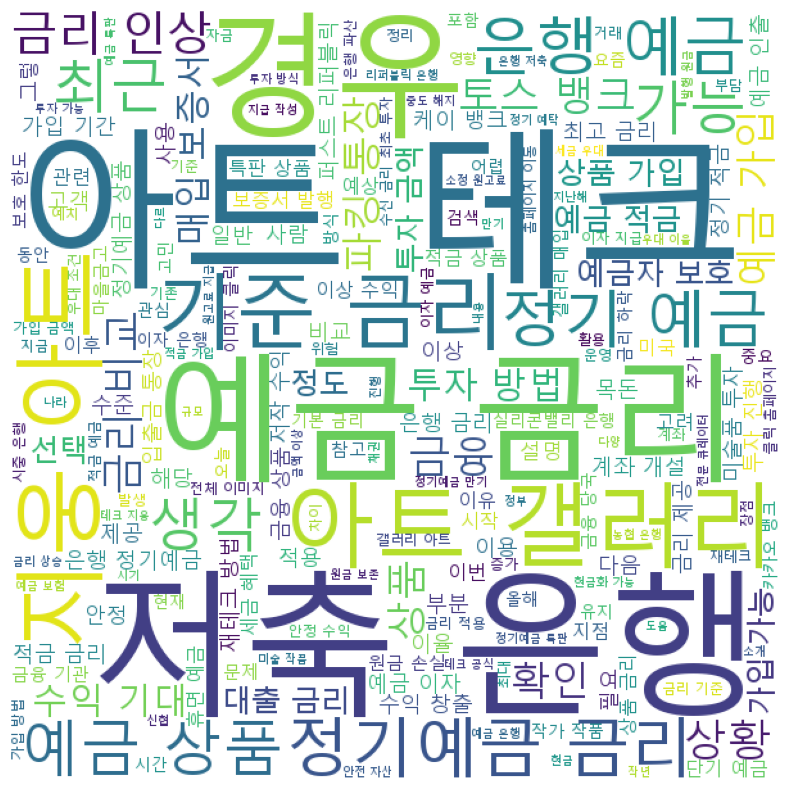

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

In [11]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(depo['전처리 된 본문'])

In [12]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [13]:
title_to_index = {k:v for k,v in zip(depo['제목'], depo.index)}
index_to_title = {v:k for k,v in title_to_index.items()}
title_to_link = {k:v for k,v in zip(depo['제목'], depo['링크'])}

In [14]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [18]:
result = get_top10_similarity('“시중은행도 불안하다?”...5대銀 정기예금 잔액 10조 ↓', cosine_sim)

[1491, 1537, 1166, 1228, 1509, 1402, 463, 1179, 1192, 1215]


In [19]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [20]:
doc_similarity_df

제목  \
0             "국내서도 탈은행 러시" 3월 정기예금 10.4조 증발한 이유는   
1                   5대 은행 예금 10조 감소…'대형은행 쏠림' 없었다   
2         기준금리보다 낮은 예금금리에 '금리노마드' 떠난다…잔액 두달째 마이너스   
3                       4%대 '실종'…5대銀 예금, 기준금리 밑돌아   
4            지난달 5대 은행 가계대출 4.6兆 감소… 정기예금도 10兆 빠져   
5                    5대 은행 가계대출 4.6조 감소…정기예금 10조↓   
6                       은행 예금금리 내리막길…‘예테크’ 시대 저무나   
7  사전신청에만 40만명 몰렸다…예금 인기 떨어졌는데 '적금'은 부활, 왜[머니뭐...   
8                      한달새 저축성예금 19조 이탈…어디로 흘러갔을까   
9                      예금금리 올리는 저축은행…연 4%대 다시 나온다   

                                                  링크  
0  https://n.news.naver.com/mnews/article/417/000...  
1  https://n.news.naver.com/mnews/article/008/000...  
2  https://n.news.naver.com/mnews/article/421/000...  
3  https://n.news.naver.com/mnews/article/011/000...  
4  https://n.news.naver.com/mnews/article/366/000...  
5  https://n.news.naver.com/mnews/article/003/001...  
6         https://blog.naver.com/ritec1/223071074138  
7  https://n.news.naver.com/mnews/article/016/000...  
8  https://n.news.naver.com/mnews/article/018/000...  
9  https://n.news.naver.com/mnews/article/648/000...

In [22]:
depo['제목'][1215]

'예금금리 올리는 저축은행…연 4%대 다시 나온다'

In [24]:
depo['본문'][1558]

'3월 예금 잔액 806조 2295억원 금리 하락 영향, 대안 투자처로 이동지난달 주요 시 중 은행의 정기예금 잔액이 10조원 가량 줄어드는 등 은행 이탈 조짐이 나타나고 있다. 특히 미국 실리콘밸리 은행(SVB) 사태 이후 ‘탈은행’ 현상이 두드러져 우려가 나오고 있다. 하지만 은행권에선 불안 심리로 인 한 탈은행 현상은 아니라 고 선을 긋고 있다. 예금금리가 3%대까지  떨어지면서 메리트가 떨어져 대안 투자처로 자금이 이동하고 있다는 것이다.4일 금융권에 따르면 5대 시 중은행(KB국민·신한·하나·우리·NH농협)의 지난달 말 기준 정기예금 잔액은 806조 2295억원으로 전월 말(815조7006억원)에 비해 약 9조5000억원 가량 감소한 것으로 나타났다. 지난 2월 계속된 예금 금리 하락에도 한 달 새 약 3조2000억원이  늘어나며 인기를 끌었던 정기예금의 수요가 돌연 줄어든 것이다.이에 SVB 사태로 인해 촉발됐던 은행 예금에 대한 불안감이 국내에까지 전파된 것 아니냐는 우려가 나오고 있다. SVB 사태가 본격화된 이달 중순 이후 정기예금 수요 감소 속도는 더 빠르게 나타났다. 예컨대 SVB 사태 직후인 지난달 15일 5대 은행의 정기예금 잔액은 813조1900억원으로  전월 말에 비해 2조5000억원 가량 줄어든 데 그쳤다. 하지만 15일부터 전월 말까지 보름간 정기예금 잔액은 약 7조원이 줄어들며, 3배가량 빠른 감소세를 기록 했다. 하지만, 업계에서는 이 같은 현상이 SVB 사태에 따른 ‘불안 심리’가 반영된 결과는 아니라 고 보고 있다. 시 중은행은 정기예금 잔액 감소가 단순히 금리 매력이 떨어진 데 따른 현상으로 판단한다 . 5대 은행의 주요 정기예금 금리(1년 만기 기준)는 이 날 기준 3.4~3.53% 수준으로, 5%대를 넘어섰던 지난해 말에 비해 약 1.5~2%포인트 가량 떨어진 상태다. 지난달 초와 비교했을 때도 금리 상단이 0.3%포인트 가량 낮아진 수준이다.시중은행 관계자는 “불안성 예금 이탈이 발생한 것이라기보다 예금 금리 하락에

In [23]:
depo['본문'][1491]

'지난 3일 오후 시민들이 서울의 한 은행 자동입출금 기 앞을 지나고 있다. / 사진=뉴스1 올 3월 국내 5대 시 중은행들의 정기예금 잔액이 한 달 만에 약 10조4000억원 줄면서 은행의 예금 이탈이 가속화하고 있다.이를 두고 유동성 위기에 직면했던 미 실리콘밸리 은행(SVB) 사례처럼 불안 우려가 고조된 데 따른 \'탈은행\' 현상이라는 분석이 나온다. 하지만 은행권에 선 5%대였던 예금 금리가 3%대로 하락하면서 금리 매력도가 떨어짐에 따라 시 중 자금이 투자처를 찾아 움직이는 \'머니무브\'라며 확대 해석을 경계하고 있다.4일 은행권에 따르면 KB국민·신한·하나·우리·NH농협 등 5대 은행의 정기예금 잔액은 지난달 말 기준 805조3384억원으로 전월(815조7006억원) 대비 10조3622억원 급감했다. 앞서 5대 은행 정기 예금 잔액은 올 1월 말 812조2500억원으로 전월 말(818조4366억원) 대비 감소하다가 2월 말 815조7006억원으로 3조4506억원 증가한 바 있다. 문제는 지난 2월에도 은행 정기예금 금리가 1년 만기 기준 3%대로 3월과 비슷한 수준을 보였을 당시에도 5대 은행의 정기예금 잔액이 한 달 새 3조5000억원 가량 늘어나며 정기예금에 대한 관심이  높았지만 지난달 돌연 정기예금 수요가 급감한 것이다. 일각에선 SVB 파산 사태로 불안해진 예금자들이 은행에서 돈을 빼간 것이 아니냐는 우려다. 실제 지난달 10일 SVB가 파산 선언을 한 이후 5대 은행에서 정기예금이 빠르게 빠져나갔다. 지난달 15일 기준 5대 은행의 정기예금 잔액은 815조7551억원으로 전월 말에 비해 오히려 545억원 늘었지만 지 난달 15~31일 빠져나간 정기예금은 10조4203억원에 이른다. 하지만 은행권에선 이 같은 정기예금 감소가 SVB 파산 사태에 따른 불안 확산 우려와 관련이 없다고 선을 긋고 있다. 정기예금 금리가 내려가면서 매력도가 떨어지자 자연스레 시 중 자금이 머니 마켓펀드(MMF) 등 새로운 투자처를 찾는 움직임이 활발해졌다는 설

## 신용카드 키워드에 대해 전처리 및 분석 진행(위와 코드 동일)

In [25]:
import pandas as pd

ch = pd.read_csv('text_data_credit_card.csv')

In [26]:
ch['본문'] = ch['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [27]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
ch['본문'] = ch['본문'].apply(correct_spacing)

# 결과 출력
print(ch['본문'])

0       올해 경기 불황으로 힘듬을 겪고 있는 분들이 작년 보다 많아진 것 같습니다. 유독 ...
1       경기 부진이 계속되면서 어려움을 겪고 있는 사람들이 많아진 것 같아요. 특히 자영업...
2       요즘 경제적으로 위기가 닥치면서 일상생활이 어려워진 분들이 굉장히 많아졌어요. 그리...
3       연초부터 경기 불황이 지속되면서 어려움을 호소하는 분들이 적잖아 진 것 같습니다. ...
4       경기 부진이 계속되면서 어려움을 겪고 있는 분들이 늘어나는 것 같습니다. 특별히 자...
                              ...                        
1482    조 바이든 미국 행정부가 고물가 시대 소비자 부담을 줄이기 위해 신용카드 연체 수수...
1483    바이든 미국 행정부가 신용카드 연체 수수료 등 과도 한 소비자 전가 비용을 내리라고...
1484    TV·인터넷 조기 해지 수수료도 대상 … 출마 선언 앞둔 바이든 직접 언급 조 바이...
1485    [앵커] 회원 수 40만 명에 육박하는 네이버 1위 명품 구매대행 카페에서 돈만 받...
1486    빌린 돈을 제 때 갚지 못하는 가계와 기업이 늘면서 대출 연체율이 빠르게 치솟고 있...
Name: 본문, Length: 1487, dtype: object


In [28]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
ch['전처리 된 본문'] = ch['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
ch = ch[['제목', '본문', '전처리 된 본문', '링크']]

In [29]:
ch.head()

제목                                                 본문  \
0  신용카드대출 선택한 방법  올해 경기 불황으로 힘듬을 겪고 있는 분들이 작년 보다 많아진 것 같습니다. 유독 ...   
1  신용카드한도대출 철저하게  경기 부진이 계속되면서 어려움을 겪고 있는 사람들이 많아진 것 같아요. 특히 자영업...   
2  신용카드한도대출 안전하게  요즘 경제적으로 위기가 닥치면서 일상생활이 어려워진 분들이 굉장히 많아졌어요. 그리...   
3  신용카드한도대출 꼼꼼하게  연초부터 경기 불황이 지속되면서 어려움을 호소하는 분들이 적잖아 진 것 같습니다. ...   
4  신용카드한도대출 진중하게  경기 부진이 계속되면서 어려움을 겪고 있는 분들이 늘어나는 것 같습니다. 특별히 자...   

                                            전처리 된 본문  \
0  올해 경기 불황 작년 부동산 거래 주인 경우 계속 금리 하락 피해 환율 상승 국민 ...   
1  경기 부진 계속 어려움 사람 자영업 경우 사회 거리 피해 물가 상승 여파 직장인 상...   
2  요즘 경제 위기 일상 생활 자영업 운영 입장 사회 거리 상당 손해 물가 환율 상승 ...   
3  연초 경기 불황 지속 어려움 호소 적잖 자영업 경우 사회 거리 손해 상당 물가 상승...   
4  경기 부진 계속 어려움 자영업 입장 사회 거리 상당 피해 물가 상승 직장인 상황 자...   

                                                 링크  
0     https://blog.naver.com/blackaira/223091474441  
1    https://blog.naver.com/jongdoosee/223093326410  
2  https://blog.naver.com/zeun_wr_0106/223093366290  
3     https://blog.naver.com/erulvoice/223092546838  
4      https://blog.naver.com/leanne21/223081533836

In [30]:
combined_text = ' '.join(ch['전처리 된 본문'].astype(str).values)

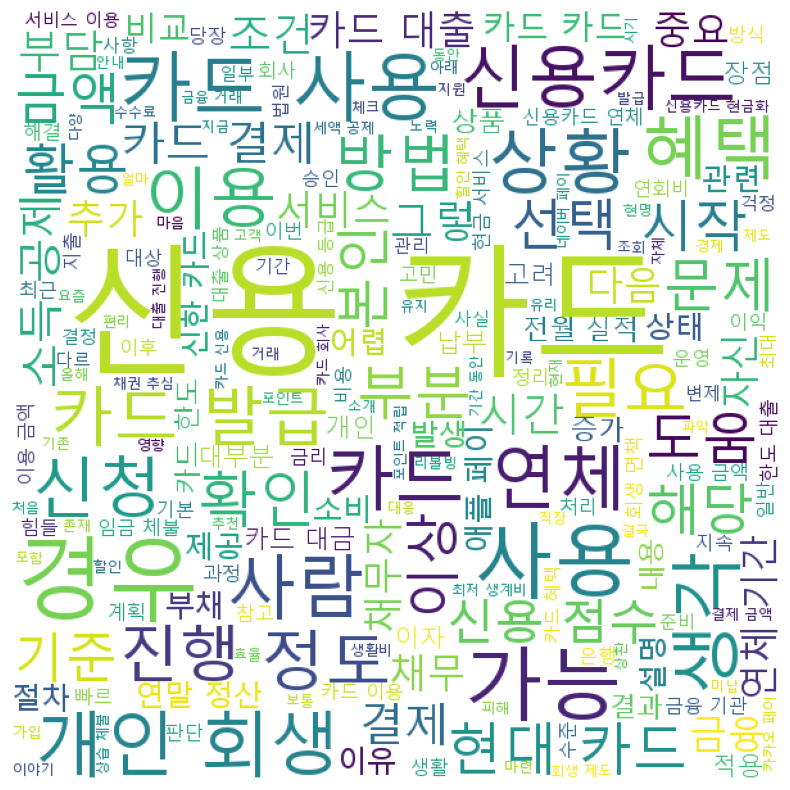

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(ch['전처리 된 본문'])

In [33]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [34]:
title_to_index = {k:v for k,v in zip(ch['제목'], ch.index)}
index_to_title = {v:k for k,v in title_to_index.items()}
title_to_link = {k:v for k,v in zip(ch['제목'], ch['링크'])}

In [35]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [36]:
result = get_top10_similarity('신용카드한도대출 진중하게', cosine_sim)

[5, 37, 128, 8, 1, 14, 132, 2, 33, 3]


In [37]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [38]:
doc_similarity_df

제목                                                링크
0  신용카드한도대출 신중하게       https://blog.naver.com/sma7489/223087928555
1  신용카드한도대출 완벽하게      https://blog.naver.com/mygale21/223092310051
2  신용카드한도대출 확실하게    https://blog.naver.com/jongdoosee/223091305068
3  신용카드한도대출 정확하게      https://blog.naver.com/hana557_/223093468048
4  신용카드한도대출 철저하게    https://blog.naver.com/jongdoosee/223093326410
5  신용카드한도대출 영리하게       https://blog.naver.com/dureyts/223094841090
6  신용카드대출 명확한 방법      https://blog.naver.com/91photoe/223088033888
7  신용카드한도대출 안전하게  https://blog.naver.com/zeun_wr_0106/223093366290
8  신용카드한도대출 간단하게       https://blog.naver.com/cutypys/223092878648
9  신용카드한도대출 꼼꼼하게     https://blog.naver.com/erulvoice/223092546838

## 체크카드 키워드에 대해 전처리 및 분석 진행(위와 코드 동일)

In [54]:
import pandas as pd

check = pd.read_csv('text_data_check_card.csv')

In [55]:
check['본문'] = check['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [56]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
check['본문'] = check['본문'].apply(correct_spacing)

# 결과 출력
print(check['본문'])

0       신용불량자 회복 통장 및 체크카드 사용 가능 여부 확인 미국 중앙은행인 연방준비제도...
1       4월 14일 블랙데이 블랙데이를 기념하여 선택한 메뉴지만 이건 슬픈 일인데. : ㅁ...
2       안녕하세요. 긍정 스텔라입니다. 연말정산 소득공제를 할 때쯤 되면 그제서야 미리미리...
3       요즘 주변을 보면 Shin han Card를 사용 중인 분들을 어렵지 않게 찾아볼 ...
4       대중교통을 이용하면 최대 30%까지 할인 혜택이 주어지는 알뜰 교통카드 ! 알고 계...
                              ...                        
1323    KB국민카드가 2023학년도 대학수학능력시험과 연말을 맞아 KB국민 체크카드 고객을...
1324    [토스뱅크 제공. 재판매 및 DB 금지] ▲ 토스뱅크는 24일부터 내년 2월까지 '...
1325    길거리서 카드 습득 후 마사지 업소에서 40여만원 결제 누범기간 중 140만원 상당...
1326    우본, 만 63세 이상 고령자 10만 명에게 15억 원 캐시백 ‘캐시백 일괄 전환 ...
1327    자동차 세 2회 이상 체납한 3910대, 과태료 부분 체납한 2640대 등 총 65...
Name: 본문, Length: 1328, dtype: object


In [57]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
check['전처리 된 본문'] = check['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
check = check[['제목', '본문', '전처리 된 본문', '링크']]

In [58]:
check.tail()

제목  \
1323                       KB국민카드, 11월의 체크카드 페스티벌   
1324             [게시판] 토스뱅크 '체크카드 주식 캐시백' 프로모션 진행   
1325       주운 카드로 마사지업소 3곳 돌며 마사지 받은 40대, 징역 1년6월   
1326  “우체국 체크카드 포인트, 현금으로 돌려준다”…고령이용자에 자동 현금 환...   
1327          광주시, “16일 새벽에 체납차량 번호판 영치 작업 진행합니다”   

                                                     본문  \
1323  KB국민카드가 2023학년도 대학수학능력시험과 연말을 맞아 KB국민 체크카드 고객을...   
1324  [토스뱅크 제공. 재판매 및 DB 금지] ▲ 토스뱅크는 24일부터 내년 2월까지 '...   
1325  길거리서 카드 습득 후 마사지 업소에서 40여만원 결제 누범기간 중 140만원 상당...   
1326  우본, 만 63세 이상 고령자 10만 명에게 15억 원 캐시백 ‘캐시백 일괄 전환 ...   
1327  자동차 세 2회 이상 체납한 3910대, 과태료 부분 체납한 2640대 등 총 65...   

                                               전처리 된 본문  \
1323  국민카드 학년도 대학 수학 능력 시험 연말 국민 체크카드 고객 대상 국민 리브 넥스...   
1324  토스 뱅크 제공 재판매 금지 토스 뱅크 내년 체크카드 주식 시백 프로모션 진행 프로...   
1325  카드 습득 마사지 업소 결제 누범 기간 상당 오토바이 절취 서울 동부 지방 법원 비...   
1326  우본 이상 고령자 캐시 시백 일괄 전환 이벤트 화면 캡처 출처 우체국 예금 보험 홈...   
1327  자동차 이상 체납 과태료 부분 체납 대상 광주 시청 전경 데일리안 기자 경기 광주시...   

                                                     링크  
1323  https://n.news.naver.com/mnews/article/123/000...  
1324  https://n.news.naver.com/mnews/article/001/001...  
1325  https://n.news.naver.com/mnews/article/421/000...  
1326  https://n.news.naver.com/mnews/article/082/000...  
1327  https://n.news.naver.com/mnews/article/119/000...

In [59]:
combined_text = ' '.join(check['전처리 된 본문'].astype(str).values)

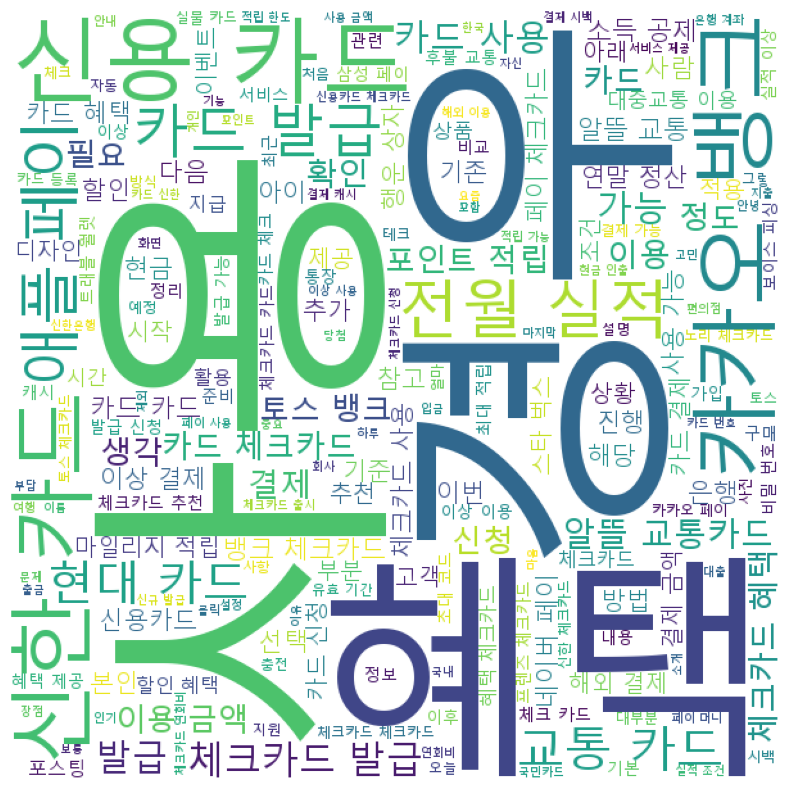

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

In [61]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(check['전처리 된 본문'])

In [62]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [63]:
title_to_index = {k:v for k,v in zip(check['제목'], check.index)}
index_to_title = {v:k for k,v in title_to_index.items()}
title_to_link = {k:v for k,v in zip(check['제목'], check['링크'])}

In [64]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [66]:
result = get_top10_similarity('KB국민카드, 11월의 체크카드 페스티벌', cosine_sim)

[1322, 1318, 1187, 1188, 103, 1037, 1321, 257, 650, 1258]


In [67]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [68]:
doc_similarity_df

제목  \
0  “‘인생네컷’ 찍고, ‘챔스’도 보자”…KB국민카드, 체크카드 페스티벌   
1    문상 받고 팬덤의 선한 영향력까지…수험생의 체크카드 200% 활용법   
2            KB국민카드, 체크카드 고객 대상 신학기 이벤트 진행   
3            KB국민카드, 2월 신학기 체크카드 고객 이벤트 진행   
4           KB국민카드, '4월에 활짝 핀 체크카드' 이벤트 진행   
5            KB국민카드, 4월 '활짝 핀 체크카드 이벤트' 진행   
6        "12년만에 리뉴얼" KB국민카드, '노리2' 체크카드 출시   
7           (카테크) KBPay  신규 국민 체크카드 발급 이벤트   
8                      KB국민카드 체크카드 캐시백 이벤트   
9              19세 생일엔 주민등록증, 14세 생일엔 선불카드   

                                                  링크  
0  https://n.news.naver.com/mnews/article/243/000...  
1  https://n.news.naver.com/mnews/article/016/000...  
2  https://n.news.naver.com/mnews/article/076/000...  
3  https://n.news.naver.com/mnews/article/366/000...  
4        https://blog.naver.com/introdo/223068162335  
5  https://n.news.naver.com/mnews/article/030/000...  
6  https://n.news.naver.com/mnews/article/417/000...  
7       https://blog.naver.com/gmldirns/223011320610  
8      https://blog.naver.com/cryptobox/223070725777  
9  https://n.news.naver.com/mnews/article/050/000...

## 경제 키워드에 대해 전처리 및 분석 진행(위와 코드 동일)

In [69]:
import pandas as pd

ec = pd.read_csv('text_data_economy.csv')

In [70]:
ec['본문'] = ec['본문'].apply(lambda x: x.replace('\u200b', ''))  #정체를 알 수 없는 \u200b문자열을 ''로 대체

In [71]:
from pykospacing import Spacing

# 띄어쓰기 교정을 수행하는 함수
def correct_spacing(text):
    spacing = Spacing()
    return spacing(text)

# 본문열의 띄어쓰기 교정 수행
ec['본문'] = ec['본문'].apply(correct_spacing)

# 결과 출력
print(ec['본문'])

0       부산사기죄 변호사 경제범죄 범위는 현재 우리나라에서 제일 많이 발행하는 경제범죄 중...
1       대체휴일 경제효과, 대신 요약해줌!📌 점차 늘어가던 대체 휴일, 코로나 19로 인해...
2       세계적인 경제지, 이코노미스트는 최근 발간된 기사(How soon and at wh...
3       게임기, 장난감, 예쁜 학용품 등 사고 싶은 것들은 너무 많은데 부모님이 주시는 용...
4       오늘 우리가 알아볼 경제용어는 수르, CES, 순차 침체, 챗GPT에 대한 용어입니...
                              ...                        
1504    “전 세계는 한류에 점령당했다”라 레푸블리카 홈페이지 캡처 이탈리아 유력 일간지 ‘...
1505    (서울=뉴스1) 안은 나 기자 = 이동근 한국경영자총협회 상근부회장이 25일 서울 ...
1506    경제 6단체 공동성명"산업현장 혼란 숙고해달라"경제계는 24일 야당의 ‘노란봉투법’...
1507    [the300] (서울=뉴스1) 이재명 기자 = 이용우 더불어민주당 비상대책위원이 ...
1508    '아 진짜, 오늘은 때려치운다' 이런 마음먹으시는 직장인들 그럴 때마다 떠오르는 생...
Name: 본문, Length: 1509, dtype: object


In [72]:
from konlpy.tag import Mecab

# 한국어 전처리 함수 정의
def preprocess_korean_text(text):
    # Mecab 형태소 분석기 초기화
    
    mecab = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")
    # 토큰화 및 품사 태깅 수행
    tokens = mecab.pos(text)
    
    # 품사가 명사 또는 형용사인 토큰들만 추출하여 리스트로 반환
    processed_tokens = [token for token, pos in tokens if pos in ['NNG', 'NNP', 'VA'] and len(token) > 1]
    
    # 공백으로 토큰들을 이어붙인 문자열 반환
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

# '본문' 열에 대해 한국어 전처리 함수 적용
ec['전처리 된 본문'] = ec['본문'].apply(preprocess_korean_text)

# 열 순서 정렬
ec = ec[['제목', '본문', '전처리 된 본문', '링크']]

In [81]:
ec.head()

제목  \
0                     부산사기죄소송전문변호사 경제범죄 범위는   
1                  대체휴일이 불러오는 경제효과, 이 정도였어?   
2  중국 경제, 이미 정점을 지난 듯(Economist, 2023.5.11)   
3                [우리동네 경제] 용돈을 주는 회사가 있다고요?   
4    [돈 되는 경제용어] 수르,CES,순차침체,챗GPT에 대해 살펴봅니다   

                                                  본문  \
0  부산사기죄 변호사 경제범죄 범위는 현재 우리나라에서 제일 많이 발행하는 경제범죄 중...   
1  대체휴일 경제효과, 대신 요약해줌!📌 점차 늘어가던 대체 휴일, 코로나 19로 인해...   
2  세계적인 경제지, 이코노미스트는 최근 발간된 기사(How soon and at wh...   
3  게임기, 장난감, 예쁜 학용품 등 사고 싶은 것들은 너무 많은데 부모님이 주시는 용...   
4  오늘 우리가 알아볼 경제용어는 수르, CES, 순차 침체, 챗GPT에 대한 용어입니...   

                                            전처리 된 본문  \
0  부산 사기죄 변호사 경제 범죄 범위 나라 발행 경제 범죄 사기죄 발생 범죄 역대 다...   
1  휴일 경제 효과 대신 요약 대체 휴일 코로나 침체 내수 경제 대체 휴일 전체 경제 ...   
2  세계 경제 코노 미스트 최근 발간 기사 중국 경제 인구 감소 부동산 시장 불황 충격...   
3  게임기 장난감 학용품 부모 용돈 부족 느낌 정기 용돈 이외 용돈 회사 용돈 파이프라...   
4  경제 용어 수르 순차 침체 용어 용어 경제 신문 생각 검색 시간 자신 경제 용어 수...   

                                                 링크  
0      https://blog.naver.com/ticojin2/223059647352  
1  https://blog.naver.com/daishin_blog/223111523522  
2      https://blog.naver.com/hong8706/223108355012  
3   https://blog.naver.com/samsungfund/223104470775  
4    https://blog.naver.com/hanyangtec/223097225083

In [74]:
combined_text = ' '.join(ec['전처리 된 본문'].astype(str).values)

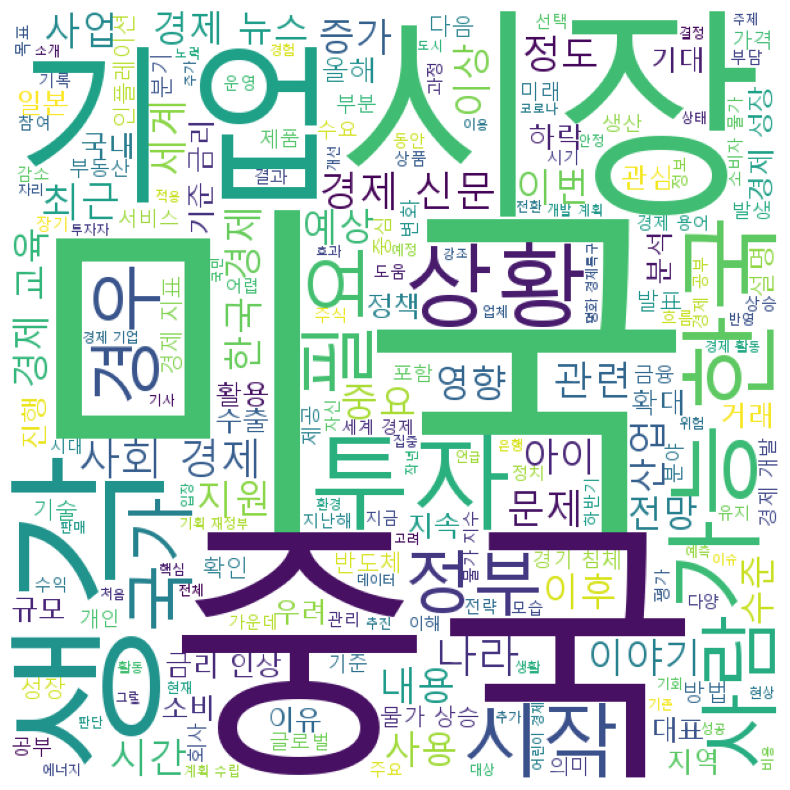

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

cloud = WordCloud(font_path = font_path, 
                  background_color = 'white', 
                  width=600, height=600, )
my_cloud1 = cloud.generate_from_text(combined_text)

arr1 = my_cloud1.to_array()

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr1)
plt.axis('off')
plt.show()

In [76]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 이미 전처리를 앞에서 진행했기 때문에 별도의 전처리를 거치지 않고 tf-idf 생성
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(ec['전처리 된 본문'])

In [77]:
# 유사도 계산
cosine_sim = cosine_similarity(tfidf_mat, tfidf_mat)

In [78]:
title_to_index = {k:v for k,v in zip(ec['제목'], ec.index)}
index_to_title = {v:k for k,v in title_to_index.items()}
title_to_link = {k:v for k,v in zip(ec['제목'], ec['링크'])}

In [79]:
def get_top10_similarity(title, cosine_sim):
    # title --> index --> title
    idx = title_to_index[title]
    title = index_to_title[idx]

    sim_score = list(enumerate(cosine_sim[idx]))
    
    # 유사도에 따라 sim_score를 내림차순 정렬
    sim_score = sorted(sim_score, key = lambda x: x[1], reverse=True)
    
    top10_documents = sim_score[1:11]
    
    # 유사도 상위 10개를 선택
    top10_documents = [x[0] for x in top10_documents]
    print(top10_documents)
    
    # 해당하는 기사나 블로그 title을 산출
    top10_titles = [index_to_title[idx] for idx in top10_documents]
    
    # 링크도 산출
    top10_links = [title_to_link[title] for title in top10_titles]

    return top10_titles, top10_links

In [82]:
result = get_top10_similarity('[돈 되는 경제용어] 수르,CES,순차침체,챗GPT에 대해 살펴봅니다', cosine_sim)

[591, 905, 389, 849, 733, 827, 328, 775, 791, 586]


In [83]:
data = {'제목': result[0] , '링크': result[1]}
doc_similarity_df = pd.DataFrame(data)

In [84]:
doc_similarity_df 

제목  \
0               경제기사를 읽어야 경제가 보인다읽고 경제공부하기   
1                투자의 길이 보이는 트렌드 경제 용어 2023   
2                    [ZOOM-IN  경제용어] 챗 GPT   
3                 경제 기초 공부, 30일 간 함께 하실래요?   
4              스노우볼 금융문맹탈출 : 경제용어 50개반 14기   
5       경제는 계속 공부해야 합니다 최신 경제 용어 해설 핵심 키워드   
6                          주택가격과 실물경제의 동조화   
7            [경제] R의 공포... #리세션 #IMF #경기침체   
8  세계경제가 언제나... ChatGPT에게 물었습니다 [G인천경제...    
9                    경기 침체와 경제 공황은 다른 것일까?   

                                                  링크  
0          https://blog.naver.com/yhj88/223060084240  
1        https://blog.naver.com/kjm2336/222936793804  
2    https://blog.naver.com/samsungfund/223071831221  
3     https://blog.naver.com/laifislove/223078289808  
4        https://blog.naver.com/mallak2/223046089757  
5    https://blog.naver.com/writer-kang/223053501454  
6        https://blog.naver.com/kjm2336/223091342728  
7    https://blog.naver.com/dream_asset/222955431983  
8      https://blog.naver.com/lovlysons/223085518862  
9  https://blog.naver.com/artmediaculture/2230864...